In [2]:
                                                                        ## L'importation des bibliothèques ##
import warnings
warnings.filterwarnings('ignore') 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels as sm
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.statespace.tools import diff
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.seasonal import seasonal_decompose
from pmdarima import auto_arima
import sklearn as skl

from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_validate

from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_squared_error

In [3]:
data_ozone = pd.read_csv("ozone_complet.txt", sep = ";")
data_beer = pd.read_csv("beer.txt", sep = ";", header = None)

# Projet 1

### Step 1: L\' analyse de la serie Beer

In [4]:
data_beer_1 = pd.date_range(start='1956-01-01', end='1991-02-01', periods= len(data_beer) )
data_beer_1 = data_beer_1.strftime('%Y-%m-%d')
data_beer["date"] = data_beer_1

In [5]:
data_beer.columns = ['beer', 'date']
data_beer['date'] = pd.to_datetime(data_beer['date'])
data_beer = data_beer.set_index('date')
data_beer.head()

,beer
date,
1956-01-01,93.2
1956-01-31,96.0
1956-03-01,95.2
1956-04-01,77.1
1956-05-01,70.9


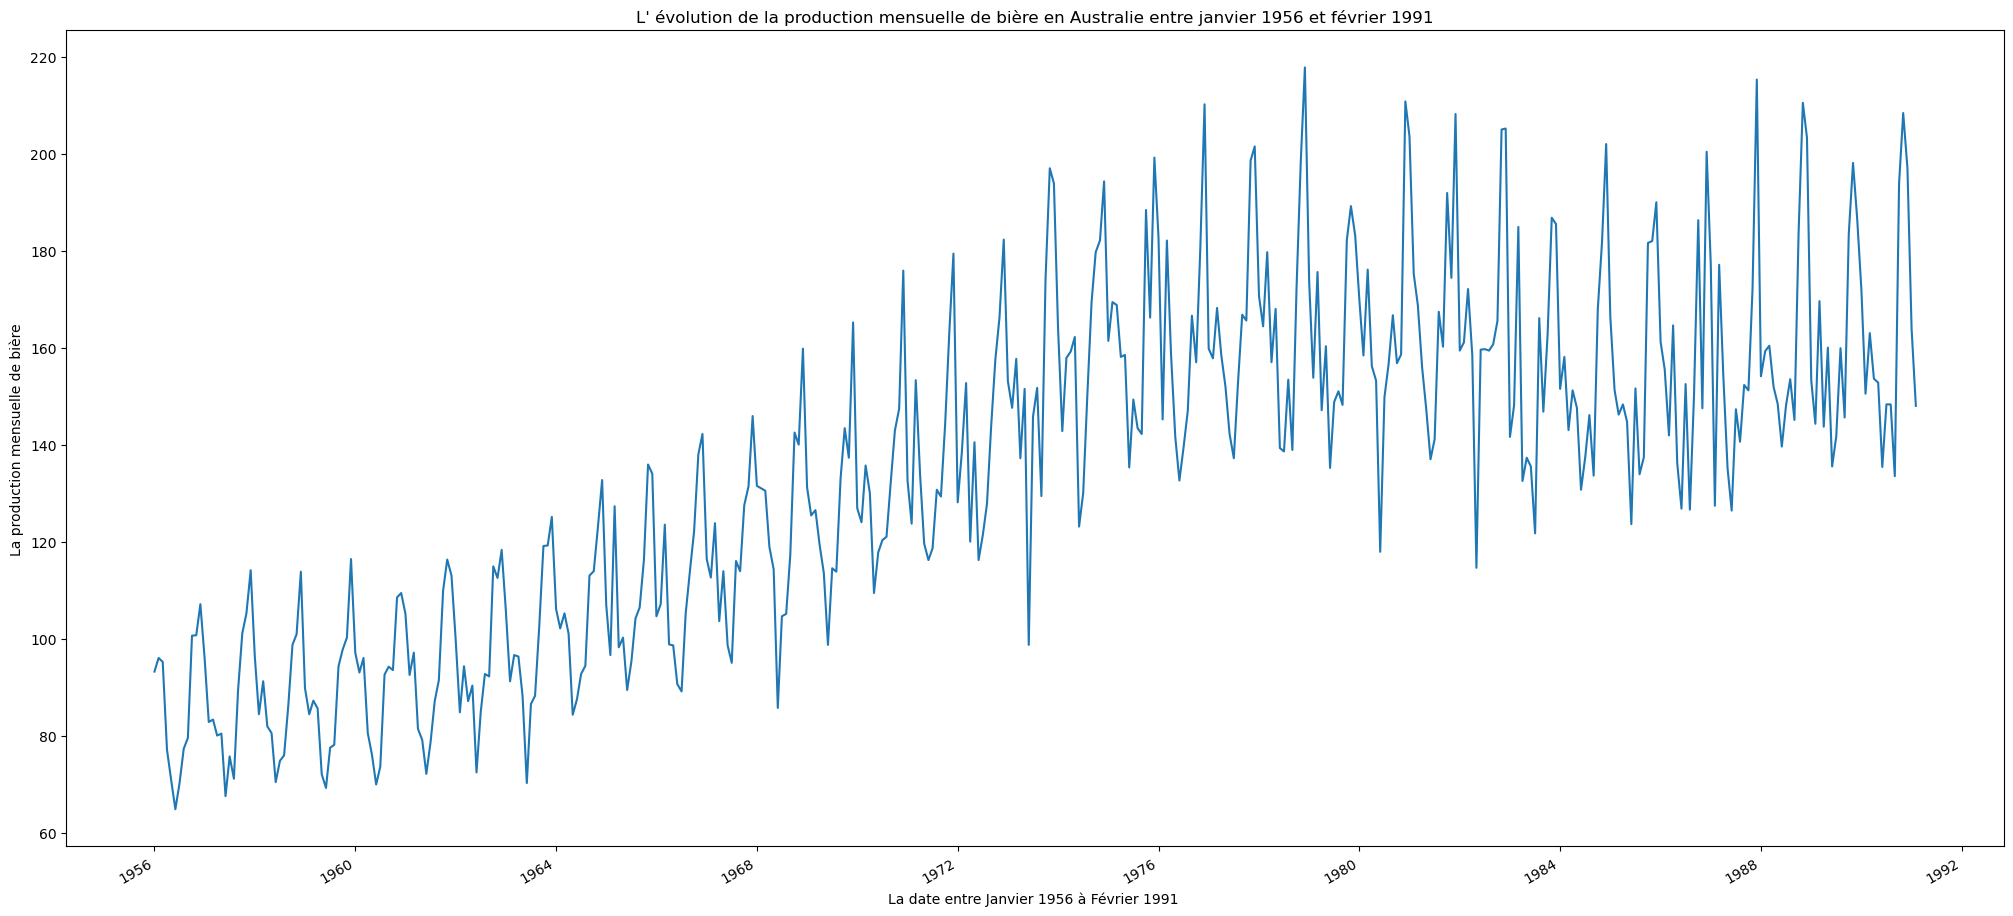

In [7]:
plt.rcParams["figure.figsize"] = [25,12]
data_beer.loc['1956' : '1991', 'beer'].plot()
plt.title('L\' évolution de la production mensuelle de bière en Australie entre janvier 1956 et février 1991')
plt.ylabel('La production mensuelle de bière')
plt.xlabel('La date entre Janvier 1956 à Février 1991 ')
#plt.rcParams["figure.figsize"] = [25,12]
plt.draw()

## -- L\'Analyse de la serie tronquée

#### Step 0 - La tendance

In [24]:
data_final = data_beer.reset_index()
data_final_trucate = data_final.set_index('date')
data_final_trucate1 = data_final_trucate.truncate(before = '1970-01-01')

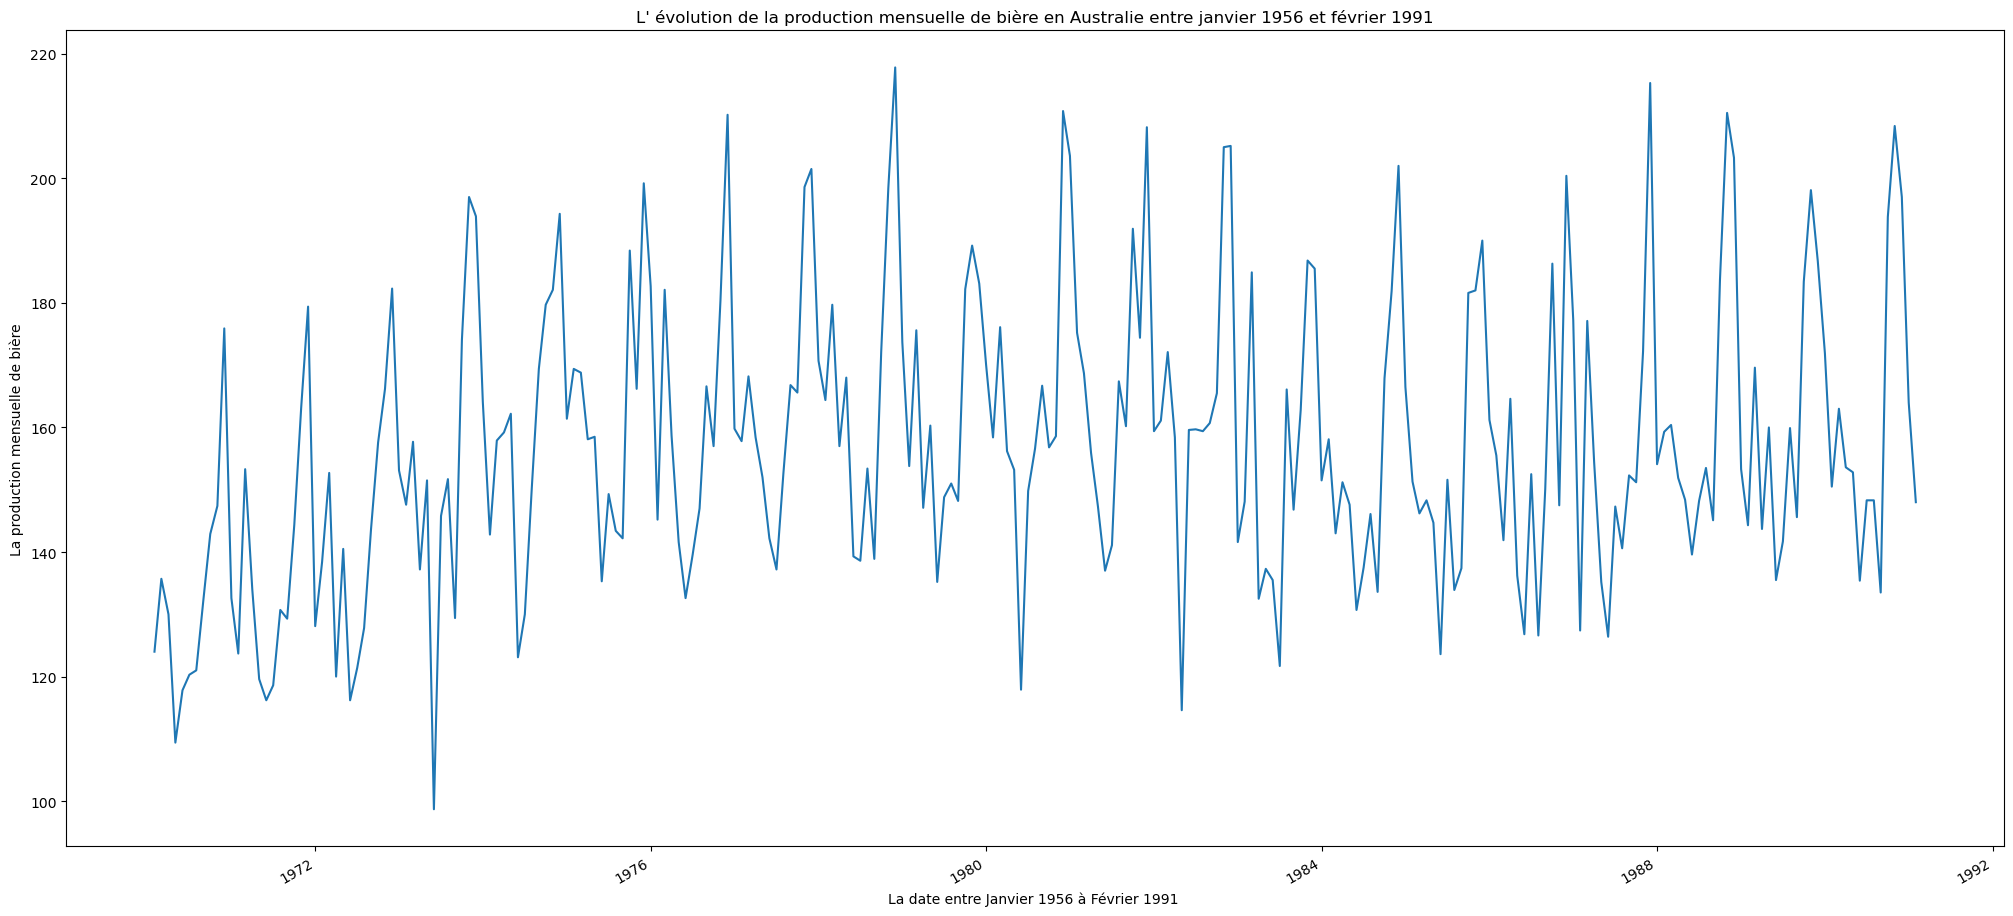

In [25]:
data_final_trucate1.loc['1956' : '1991', 'beer'].plot()
plt.title('L\' évolution de la production mensuelle de bière en Australie entre janvier 1956 et février 1991')
plt.ylabel('La production mensuelle de bière')
plt.xlabel('La date entre Janvier 1956 à Février 1991 ')
plt.rcParams["figure.figsize"] = [25,12]
plt.draw()

plt.savefig('C:/Users/dell/Desktop/Msc_ENSAI/Series_Temporelles/Evaluation-20230107/tendance.jpg')
plt.show()

In [26]:
data_final_trucate2 = data_final_trucate1.reset_index()
data_final_trucate2_train = data_final_trucate2.loc[data_final_trucate2['date'] < "1988-01-01"]
data_final_trucate2_test = data_final_trucate2.loc[data_final_trucate2['date'] >= "1988-01-01"]

In [27]:
data_final_trucate2_test.head()

,date,beer
215,1988-01-01,154.1
216,1988-02-01,159.3
217,1988-03-02,160.4
218,1988-04-02,151.9
219,1988-05-02,148.4


In [28]:
data_1 = data_final_trucate2.set_index('date')

In [29]:
data_final_trucate2_train = data_final_trucate2_train.set_index('date')
data_final_trucate2_test = data_final_trucate2_test.set_index('date')

#### Step 1- La stationnarité

In [30]:
## En visualisant la représentation des autocorrélations, on constate que la sortie ACF tend lentement vers 0. Par conséquent les sources de non-stationarité 
## sont évidentes. Dans ces conditions, nous utiliserons la différenciation afin d'obtenir une nouvelle série temporelle.

In [31]:
#Fonction affichant le Test de Dickey–Fuller avec les autocorrélogrammes ACF et PACF
def tsplot(y, lags=None, figsize=(20, 10), style='bmh'):
    """
        Test de Dickey–Fuller 
        avec Autocorrélogrammes ACF et PACF
        
    """
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
        
    with plt.style.context(style):    
        fig = plt.figure(figsize=figsize)
        layout = (2, 2)
        ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1, 0))
        pacf_ax = plt.subplot2grid(layout, (1, 1))
        
        y.plot(ax=ts_ax)
        p_value = sm.tsa.stattools.adfuller(y)[1]
        ts_ax.set_title('Time Series Analysis Plots\n Dickey-Fuller: p={0:.5f}'.format(p_value))
        plot_acf(y, lags=lags, ax=acf_ax)
        plot_pacf(y, lags=lags, ax=pacf_ax)
        plt.tight_layout()

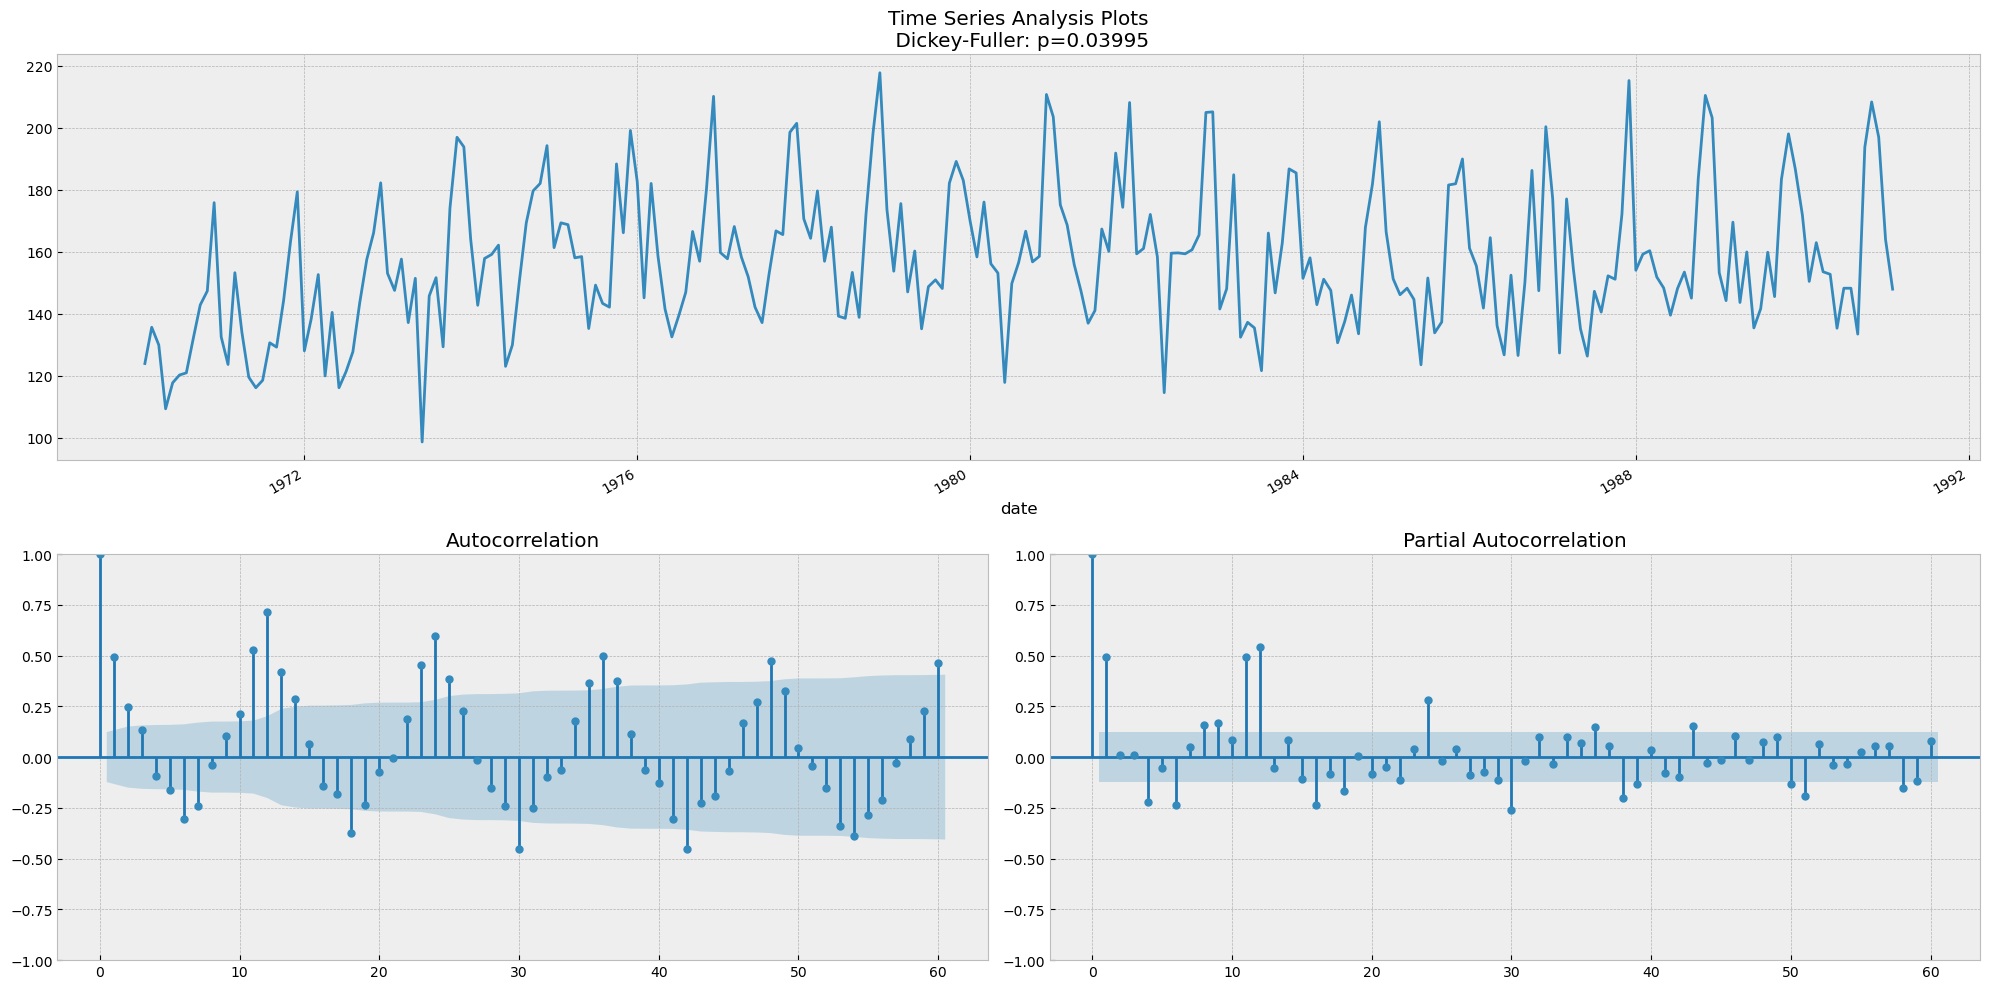

In [32]:
tsplot(data_1['beer'], lags=60)

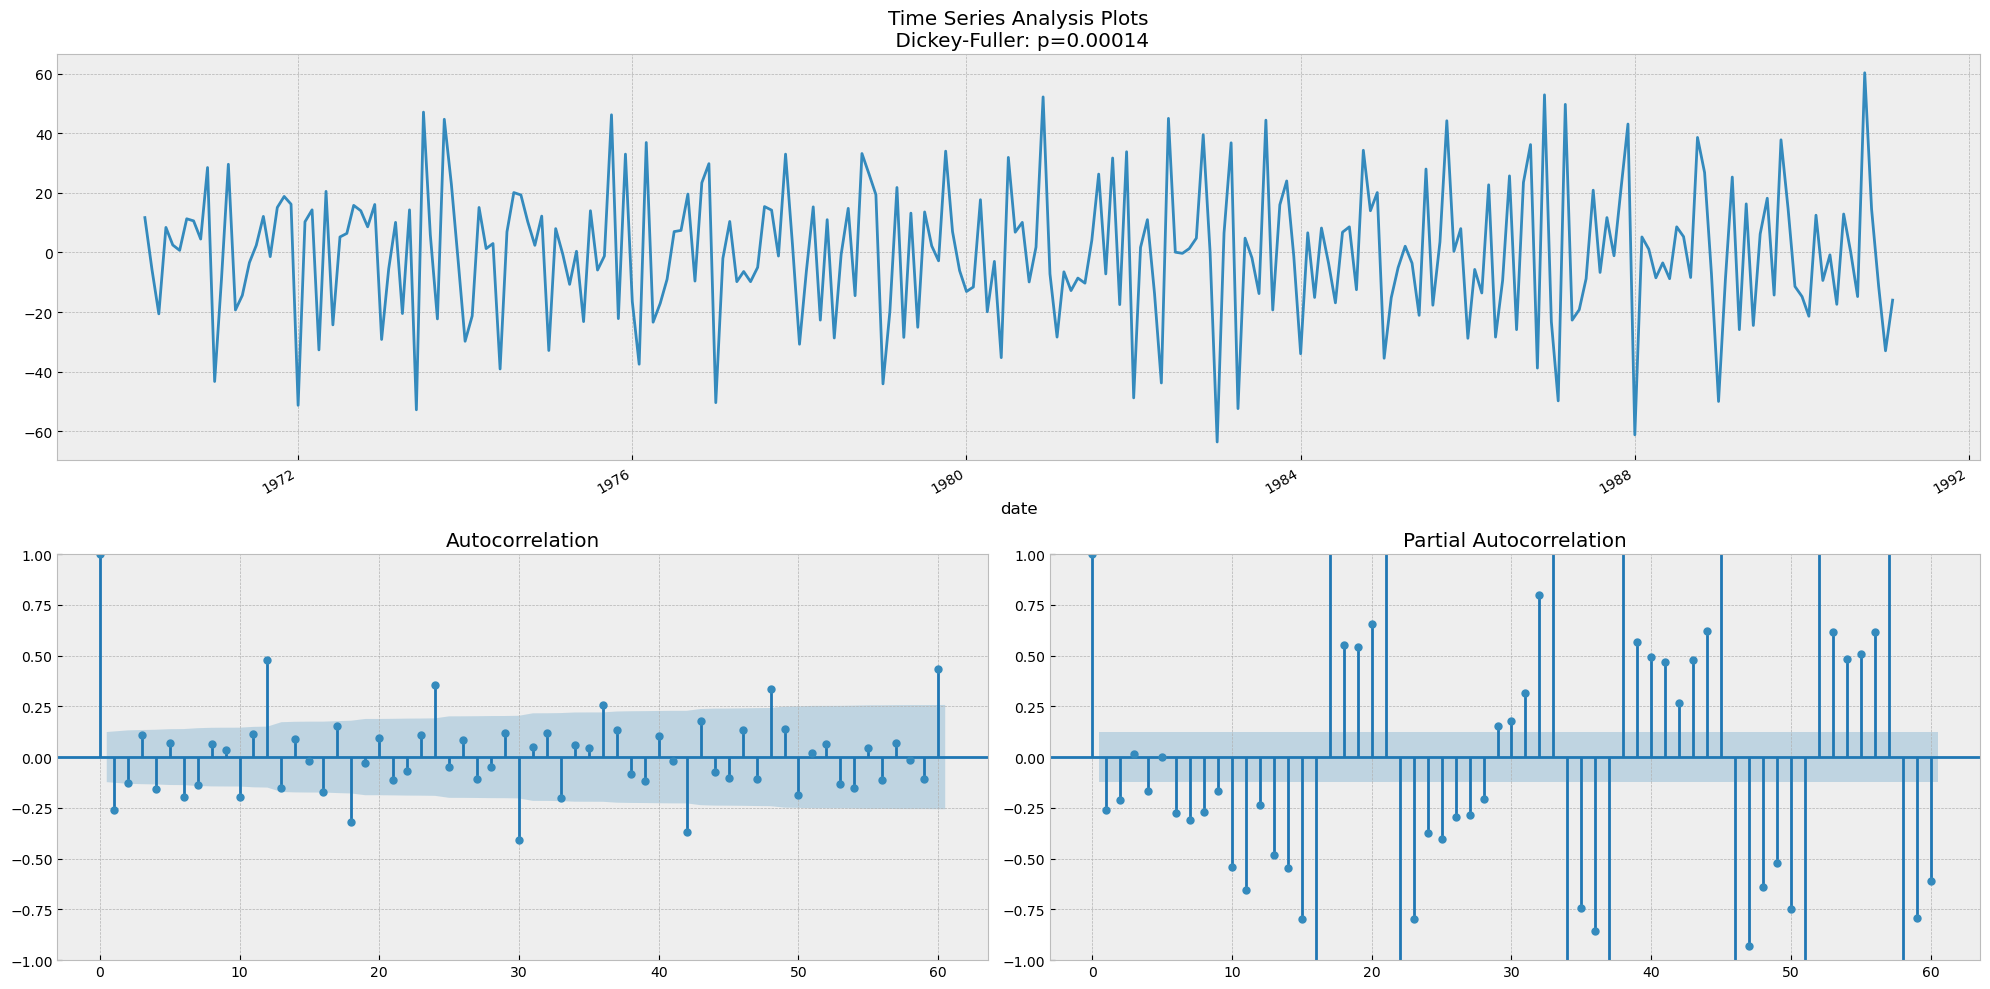

In [33]:
#Première différenciation d'ordre 1 par la méthode .shift()
df_diff1 = data_1['beer'] - data_1['beer'].shift(1)
tsplot(df_diff1[1:], lags=60)

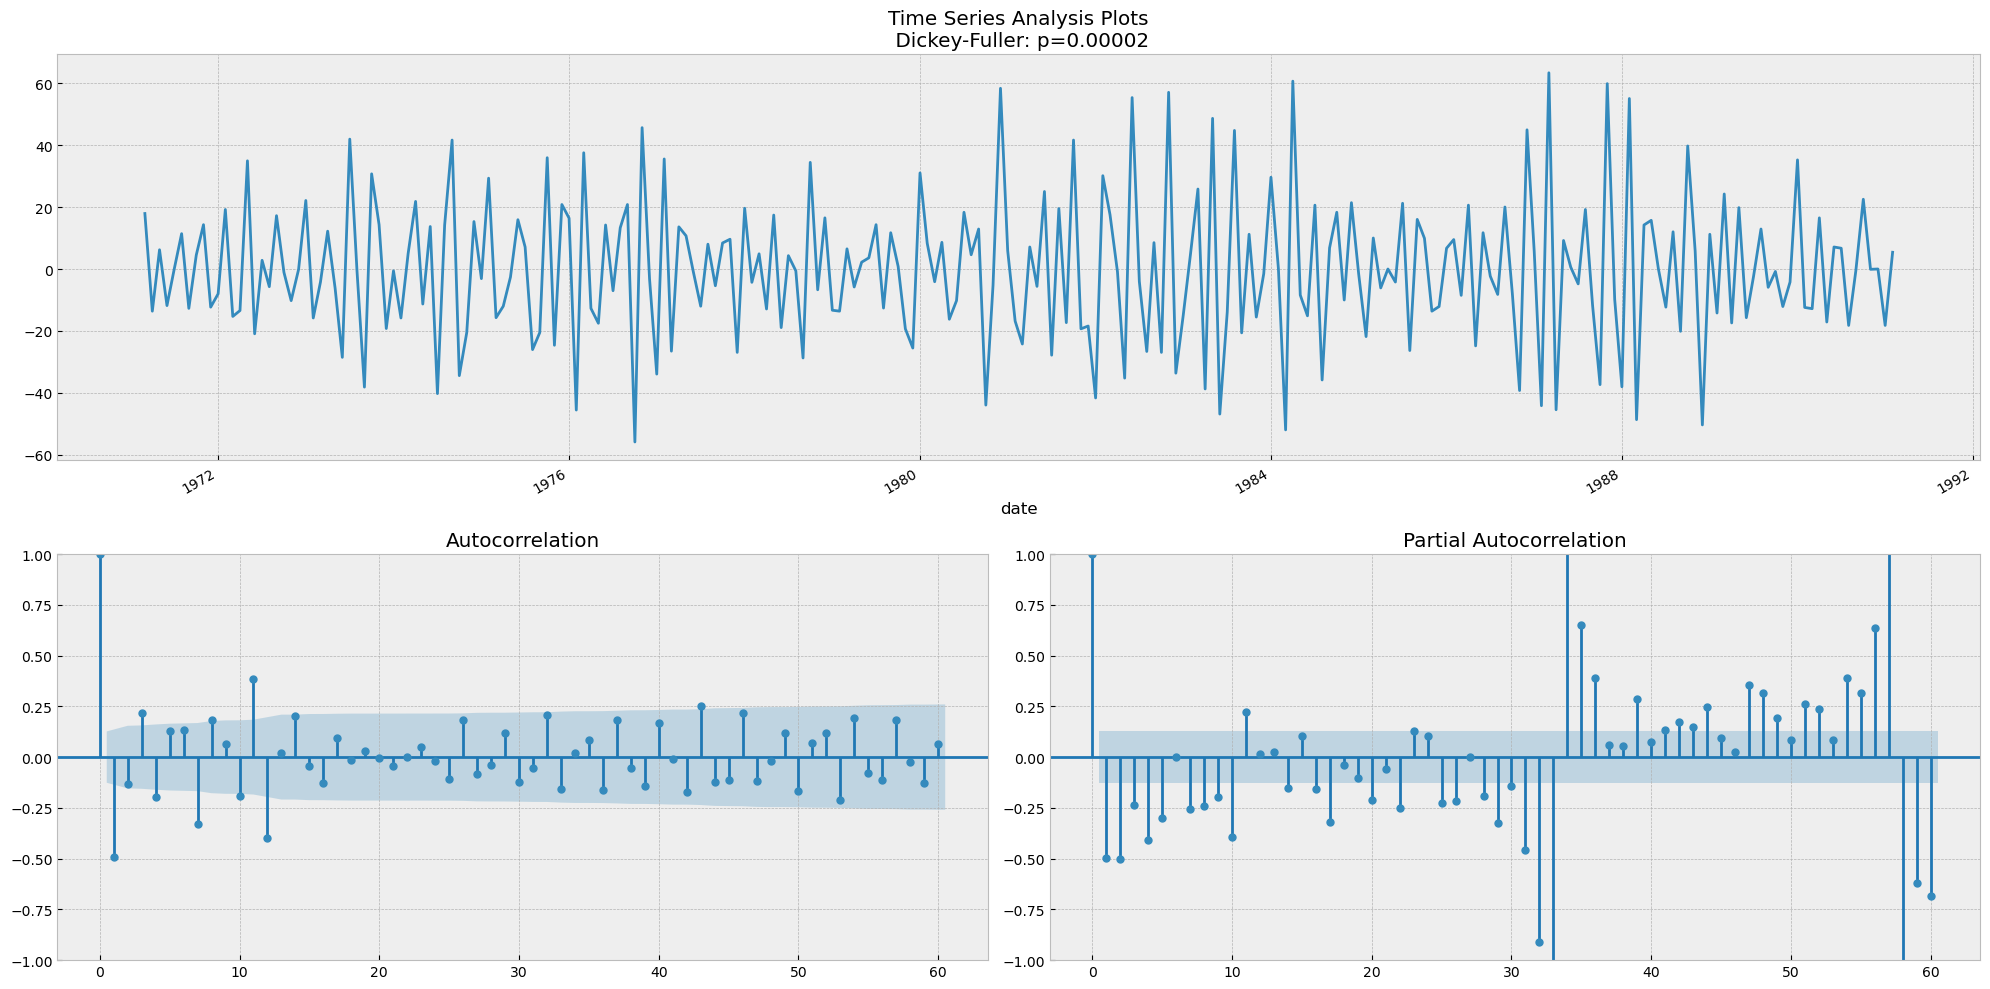

In [34]:
#Seconde différenciation d'ordre 12 
df_diff1_12 = df_diff1 - df_diff1.shift(12)
tsplot(df_diff1_12[13:], lags=60)

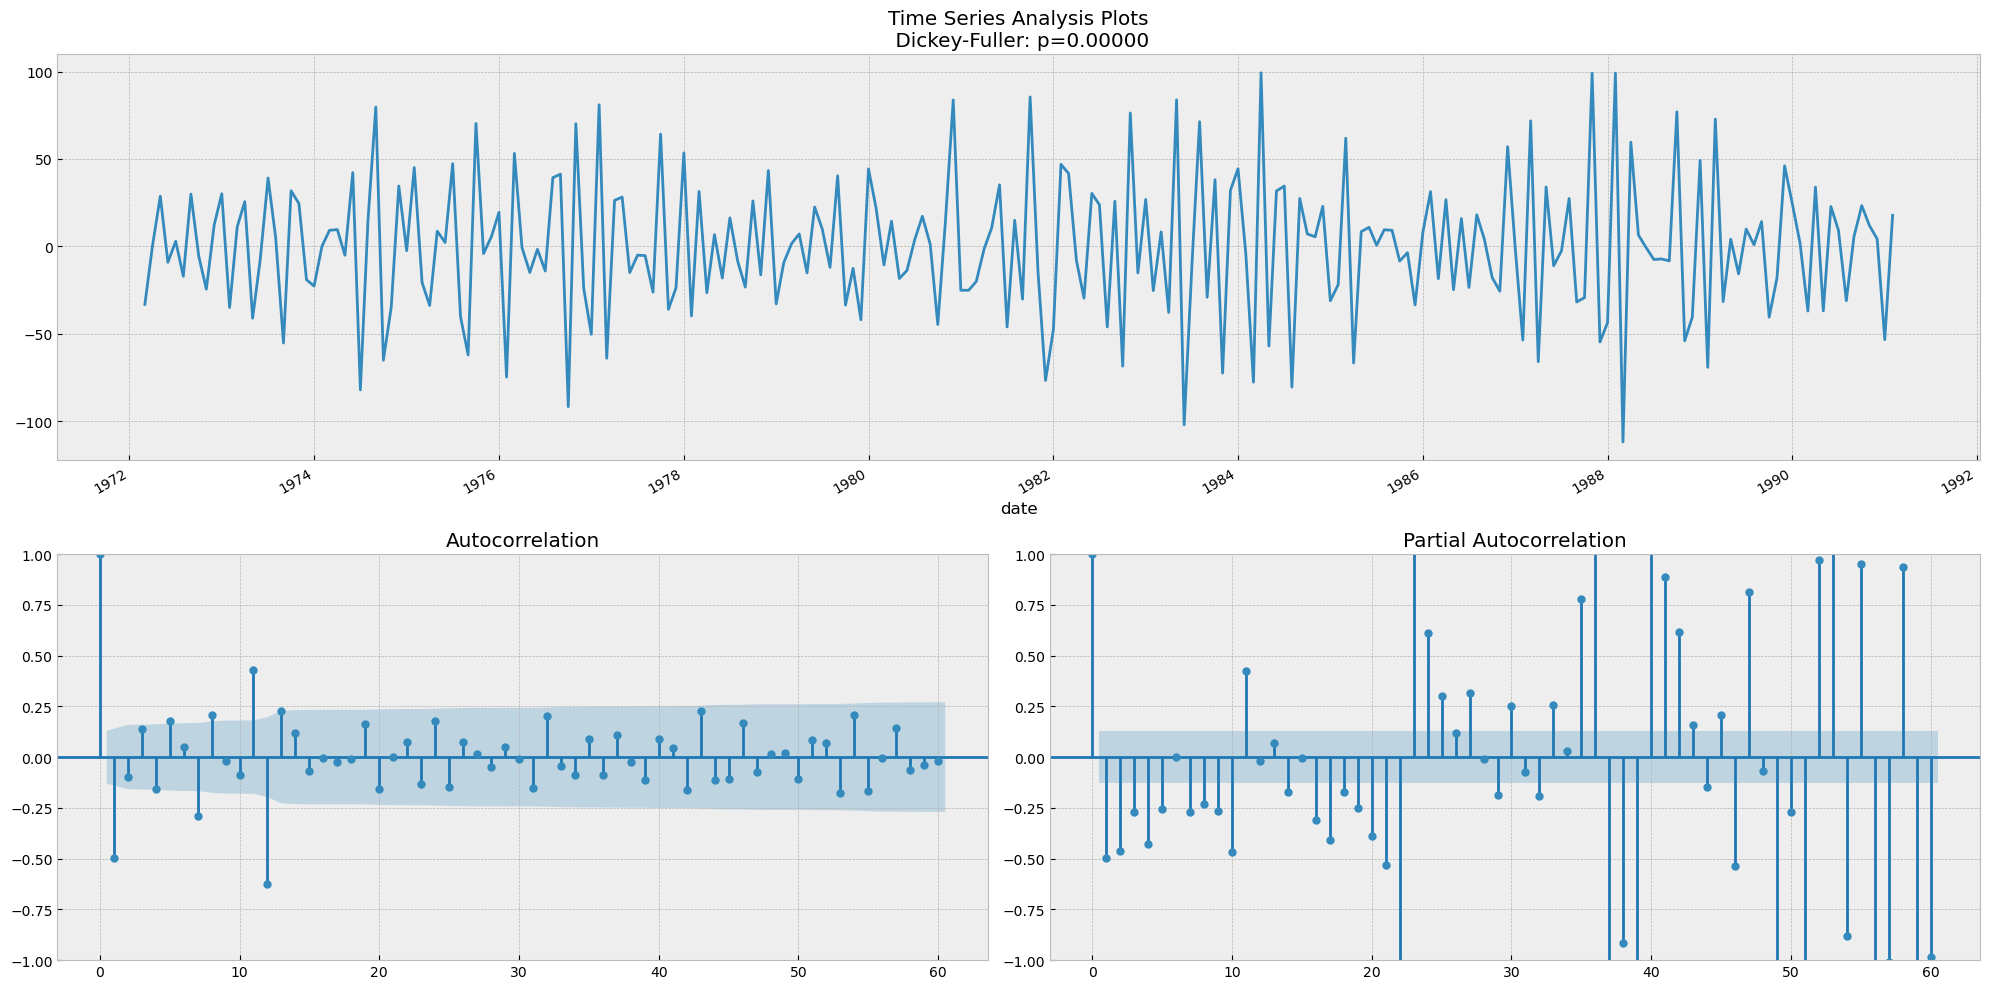

In [35]:
df_diff1_13 = df_diff1_12 - df_diff1_12.shift(12)
tsplot(df_diff1_13[25:], lags=60)

In [36]:
#Détermination du meilleur modèle de prévision 
from time import time
import itertools
import statsmodels.api as sm
import statsmodels.tsa.statespace.sarimax
DUREE_PREDITE = 12 #prédiction sur 12 mois
troncature = DUREE_PREDITE
y = data_1['beer']
#y_prevision = data_final_trucate2_test['beer']

#Calcul de toutes les combinaisons de p, d et q
pdq_list = list(itertools.product(range(3),
                             range(2), 
                             range(3)
           ))

#Calcul de toutes les combinaisons de P, D et Q
PDQ_list = [ (*val, 12) for val in list(itertools.product(
                            range(3), 
                            range(2), 
                            range(3))
            )]


#Nombre de configurations total pour un modèle SARIMA
n = len(pdq_list) * len(PDQ_list)

#Dataframe pour stockage des valeurs
results_SARIMA = pd.DataFrame({'modele':[], 'aic':[], 'bic':[], 'ljungbox':[], 'pvalues':[]})
counter = 1
s_time = time()

#Itération sur toutes les combinaisons
for pdq in pdq_list:
    for PDQ in PDQ_list:
        try:
            #Instanciation et entrainement du modèle SARIMA
            mod = sm.tsa.statespace.SARIMAX(np.asarray(y), order = pdq, seasonal_order = PDQ, 
                          enforce_stationarity=False, enforce_invertibility=False)
            result = mod.fit()
                    
            #Intégration des indicateurs dans le précédent dataframe
            results_SARIMA = results_SARIMA.append({'modele':f"{pdq}x{PDQ}", 
                            'aic': result.aic, 
                            'bic': result.bic,
                            'ljungbox': statsmodels.stats.diagnostic.acorr_ljungbox(result.resid, lags=12).iloc[:,1].mean(),
                            'pvalues': result.pvalues.min()}, 
                            ignore_index=True)
        except:
            continue
            
        counter += 1

In [37]:
counter

325

In [38]:
#Sélection des modèles SARIMA les plus optimaux selon les tests de significativité des paramètres 
#et de blancheur du résidu sont validés au niveau 5%
results_SARIMA_filter = results_SARIMA[(results_SARIMA['ljungbox'] > 0.05)]
results_SARIMA_filter = results_SARIMA_filter[results_SARIMA_filter['pvalues'] < 0.05]

In [39]:
#Utilisation de la fonction .rank() pour déterminer la position de chaque modèle selon la minimisation AIC / BIC
results_SARIMA_filter['rank_aic'] = results_SARIMA_filter['aic'].rank(ascending=True)
results_SARIMA_filter['rank_bic'] = results_SARIMA_filter['bic'].rank(ascending=True)

In [40]:
#Visualisation des 30 modèles les plus performants sur les 324 initiaux
def highlight_greaterthan(x):
    if x.rank_aic == 25:
        return ['background-color: #2399f9']*7
    else:
        return ['background-color: None']*7

results_SARIMA_filter.sort_values('rank_aic', ascending=True)[:30].style.apply(highlight_greaterthan, axis=1)

,modele,aic,bic,ljungbox,pvalues,rank_aic,rank_bic
209,"(1, 1, 2)x(1, 1, 2, 12)",1680.930468,1704.459513,0.145755,0.000000,1.000000,2.000000
203,"(1, 1, 2)x(0, 1, 2, 12)",1681.393719,1701.561472,0.108293,0.000000,2.000000,1.000000
215,"(1, 1, 2)x(2, 1, 2, 12)",1682.996911,1709.887249,0.155725,0.000000,3.000000,5.000000
311,"(2, 1, 2)x(0, 1, 2, 12)",1684.053982,1707.583027,0.065084,0.000000,4.000000,4.000000
101,"(0, 1, 2)x(1, 1, 2, 12)",1690.577956,1710.745709,0.109151,0.000000,5.000000,6.000000
95,"(0, 1, 2)x(0, 1, 2, 12)",1690.686498,1707.492959,0.100654,0.000000,6.000000,3.000000
293,"(2, 1, 1)x(0, 1, 2, 12)",1691.112249,1711.308105,0.299306,0.000000,7.000000,7.000000
299,"(2, 1, 1)x(1, 1, 2, 12)",1692.338116,1715.899949,0.277793,0.000000,8.000000,8.000000
107,"(0, 1, 2)x(2, 1, 2, 12)",1692.573469,1716.102514,0.109165,0.000000,9.000000,9.000000
322,"(2, 1, 2)x(2, 1, 1, 12)",1693.926621,1720.854429,0.060813,0.000000,10.000000,12.000000


In [41]:
#! pip install pmdarima

In [42]:
#Instanciation et entrainement du modèle SARIMA via statsmodels (1, 1, 2)x(1, 1, 2, 12) 
#order= (1, 1, 2), seasonal_order = (1, 1, 2, 12)
#(0, 1, 2) (0, 1, 1, 12)
model = SARIMAX(np.asarray(y), order= (0, 1, 2), seasonal_order = (0, 1, 1, 12))
results = model.fit()
print(results.summary())

                                      SARIMAX Results                                       
Dep. Variable:                                    y   No. Observations:                  253
Model:             SARIMAX(0, 1, 2)x(0, 1, [1], 12)   Log Likelihood                -943.554
Date:                              Mon, 27 Feb 2023   AIC                           1895.108
Time:                                      13:36:07   BIC                           1909.030
Sample:                                           0   HQIC                          1900.718
                                              - 253                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -1.1910      0.062    -19.261      0.000      -1.312      -1.070
ma.L2          0.30

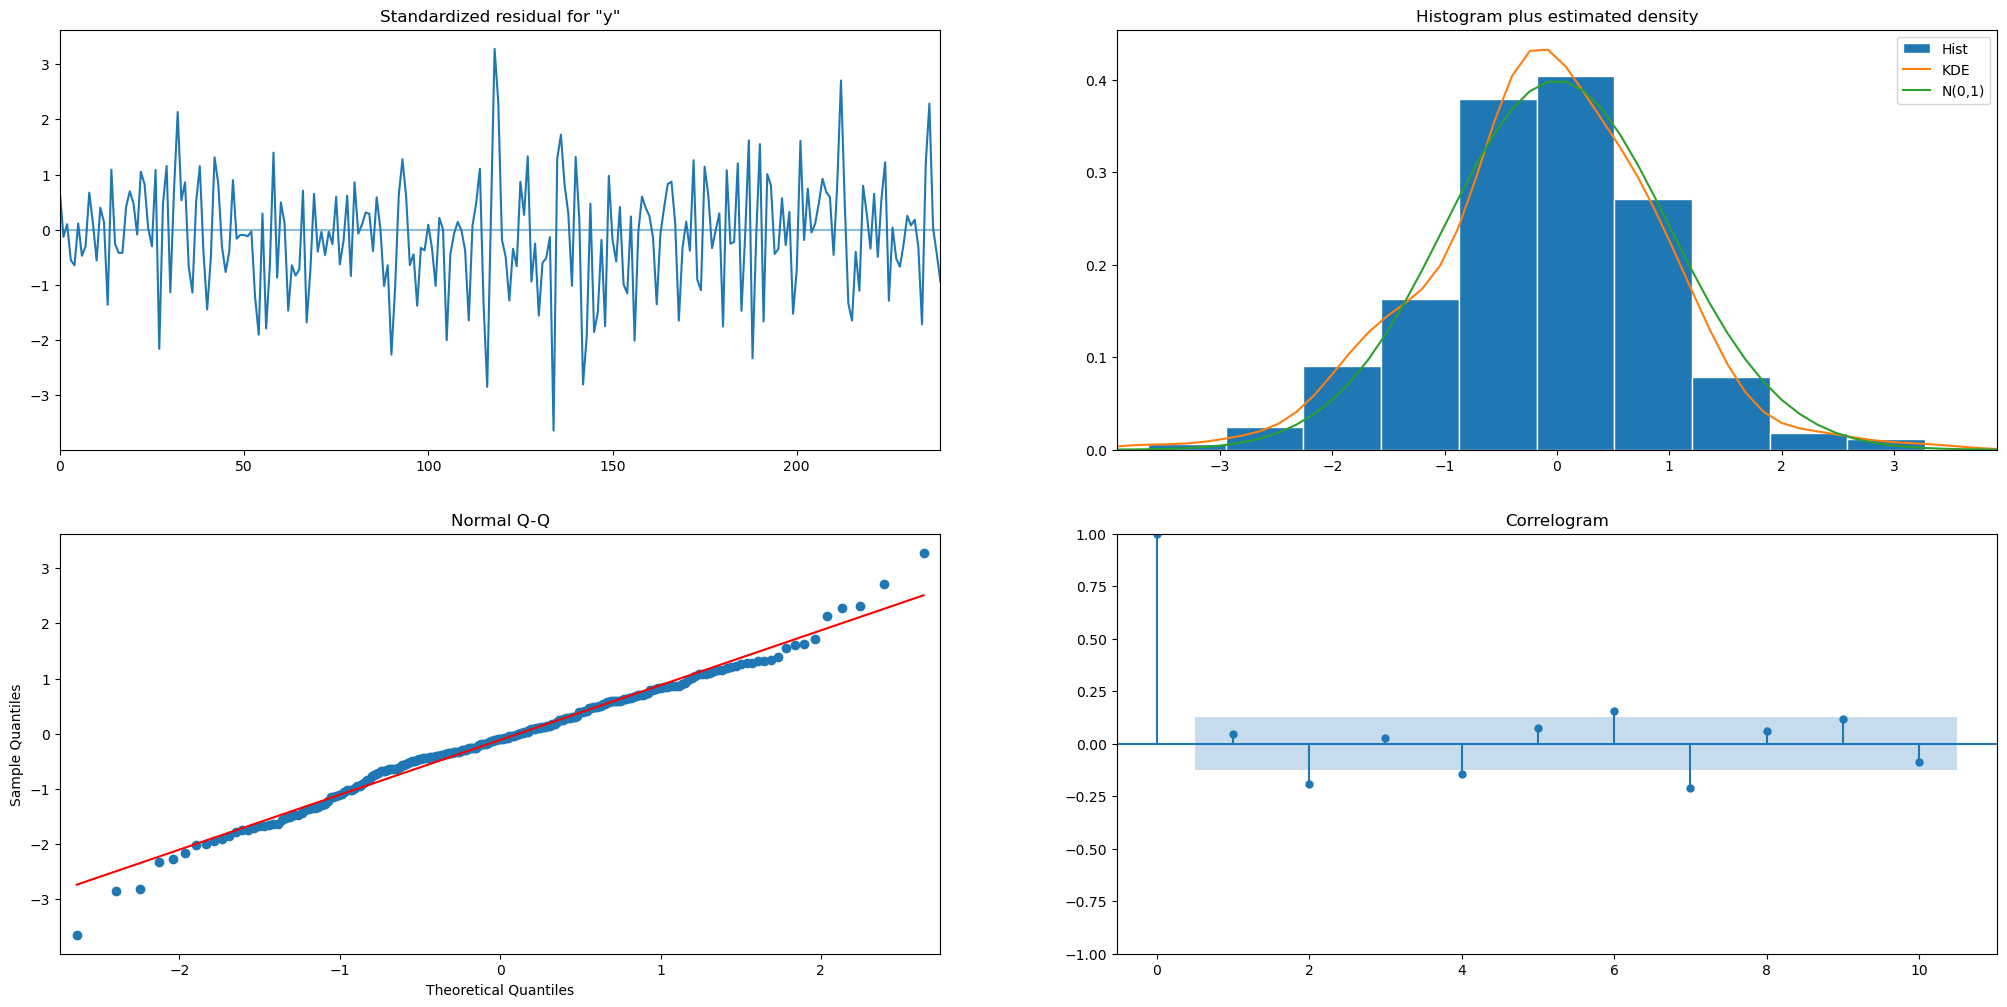

In [43]:
#La fonction .plot_diagnostics() permet d'établir un diagnostic rapide du modèle SARIMA identifié  
fig = results.plot_diagnostics()

In [44]:
#Test de Shapiro-Wilk
from scipy.stats import shapiro
shapiro(results.resid)

ShapiroResult(statistic=0.8537936210632324, pvalue=9.666278160660926e-15)

In [45]:
#Test de Jarque-Bera
results.test_normality("jarquebera")[0][1]

0.020291560664603928

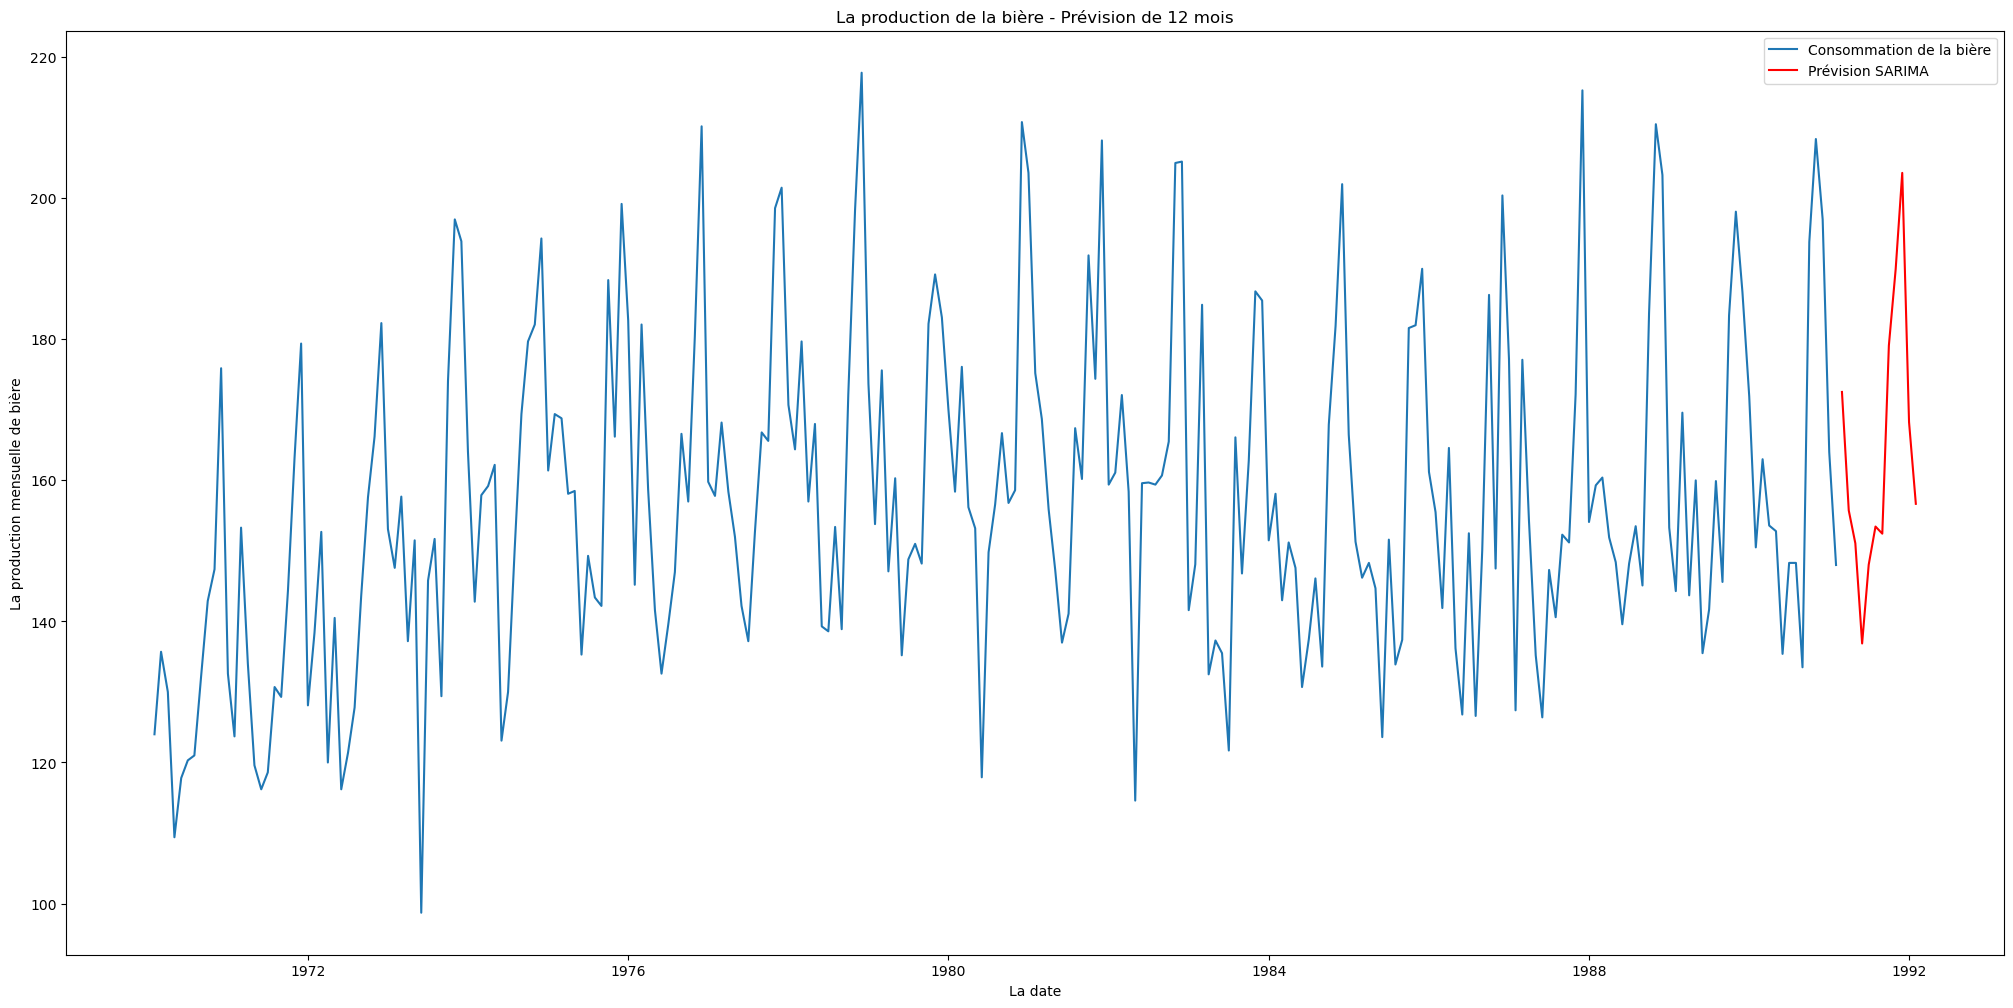

In [46]:
#Visualisation de la prévision à 12 mois par la méthode SARIMA
pred_model = results.get_forecast(12)
pred = pred_model.predicted_mean
data_1['beer']
plt.plot(data_1['beer'], label='Consommation de la bière')
plt.plot(pd.date_range(data_1.index[len(data_1)-1], periods=12, freq='M'), pred, color='r', label='Prévision SARIMA')

plt.ylabel('La production mensuelle de bière')
plt.xlabel('La date')
plt.title("La production de la bière - Prévision de 12 mois")
plt.legend()

plt.savefig('C:/Users/dell/Desktop/Msc_ENSAI/Series_Temporelles/Evaluation-20230107/sarima_prevision2019.jpg')
plt.show() 

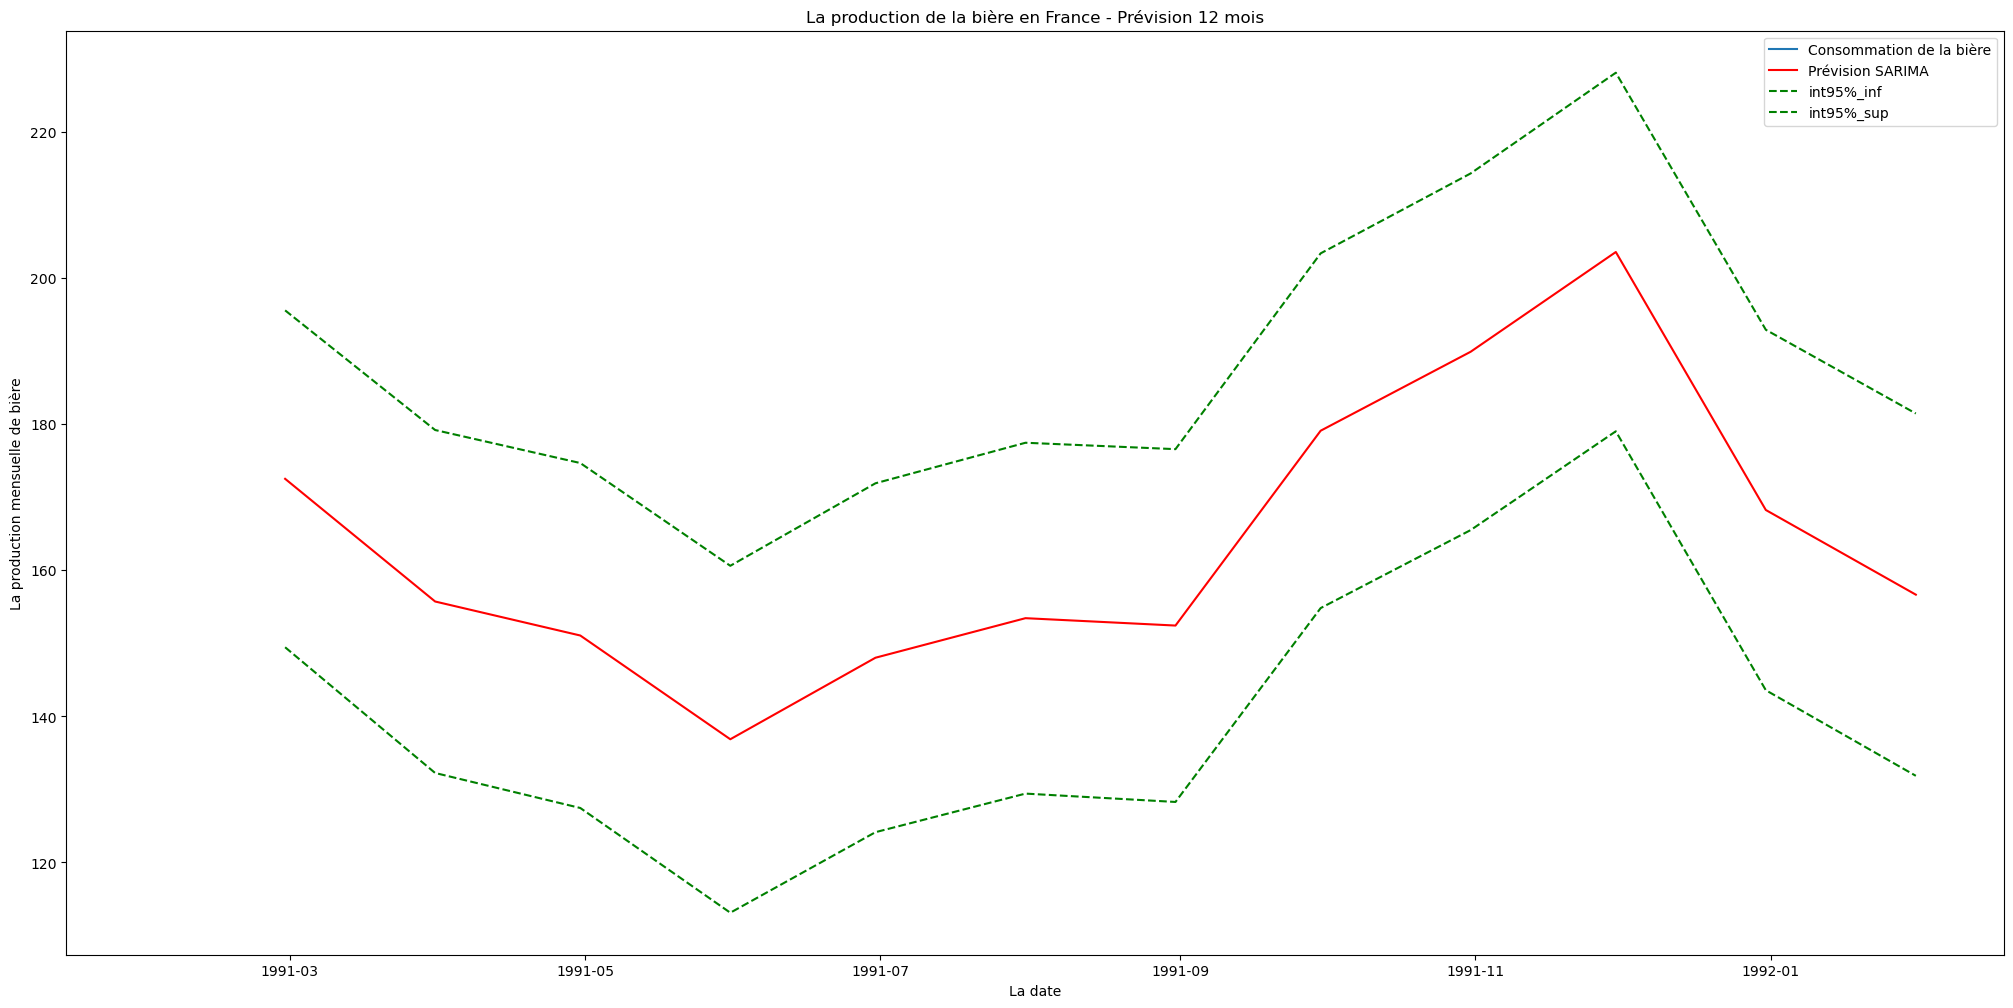

In [47]:
#Visualisation des intervalles de confiance sur la prévision à 12 mois
pred_model = results.get_forecast(12)
pred = pred_model.predicted_mean

pred_l = [(elt[0]) for elt in pred_model.conf_int(alpha=0.05)]
pred_u = [(elt[1]) for elt in pred_model.conf_int(alpha=0.05)]

plt.plot(data_1['beer'].iloc[-1:], label='Consommation de la bière')
plt.plot(pd.date_range(data_1.index[len(data_1)-1], periods=12, freq='M'), pred, color='r', label='Prévision SARIMA')
plt.plot(pd.date_range(data_1.index[len(data_1)-1], periods=12, freq='M'), 
         pred_l, color='g', linestyle='--', label='int95%_inf')
plt.plot(pd.date_range(data_1.index[len(data_1)-1], periods=12, freq='M'), 
         pred_u, color='g', linestyle='--', label='int95%_sup')
plt.ylabel('La production mensuelle de bière')
plt.xlabel('La date')
plt.title("La production de la bière en France - Prévision 12 mois")
plt.legend()

plt.savefig('C:/Users/dell/Desktop/Msc_ENSAI/Series_Temporelles/Evaluation-20230107/sarima_prevision2019_int95.jpg')
plt.show()

### - Step : Analyse a posteriori

In [48]:
#data_final_trucate2_train['beer']
#data_final_trucate2_test['beer']

In [49]:
model_tronc = SARIMAX(np.asarray(data_final_trucate2_train['beer']), order= (0, 1, 2), seasonal_order = (0, 1, 1, 12))
results_tronc = model_tronc.fit()
print(results_tronc.summary())

print('Retard : p-value')
for elt in [6, 12, 18, 24, 30, 36]:
    print('{} : {}'.format(elt, statsmodels.stats.diagnostic.acorr_ljungbox(result.resid, lags=elt).iloc[:,1].mean()))

                                      SARIMAX Results                                       
Dep. Variable:                                    y   No. Observations:                  215
Model:             SARIMAX(0, 1, 2)x(0, 1, [1], 12)   Log Likelihood                -797.866
Date:                              Mon, 27 Feb 2023   AIC                           1603.732
Time:                                      13:36:17   BIC                           1616.965
Sample:                                           0   HQIC                          1609.086
                                              - 215                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -1.2201      0.065    -18.854      0.000      -1.347      -1.093
ma.L2          0.33

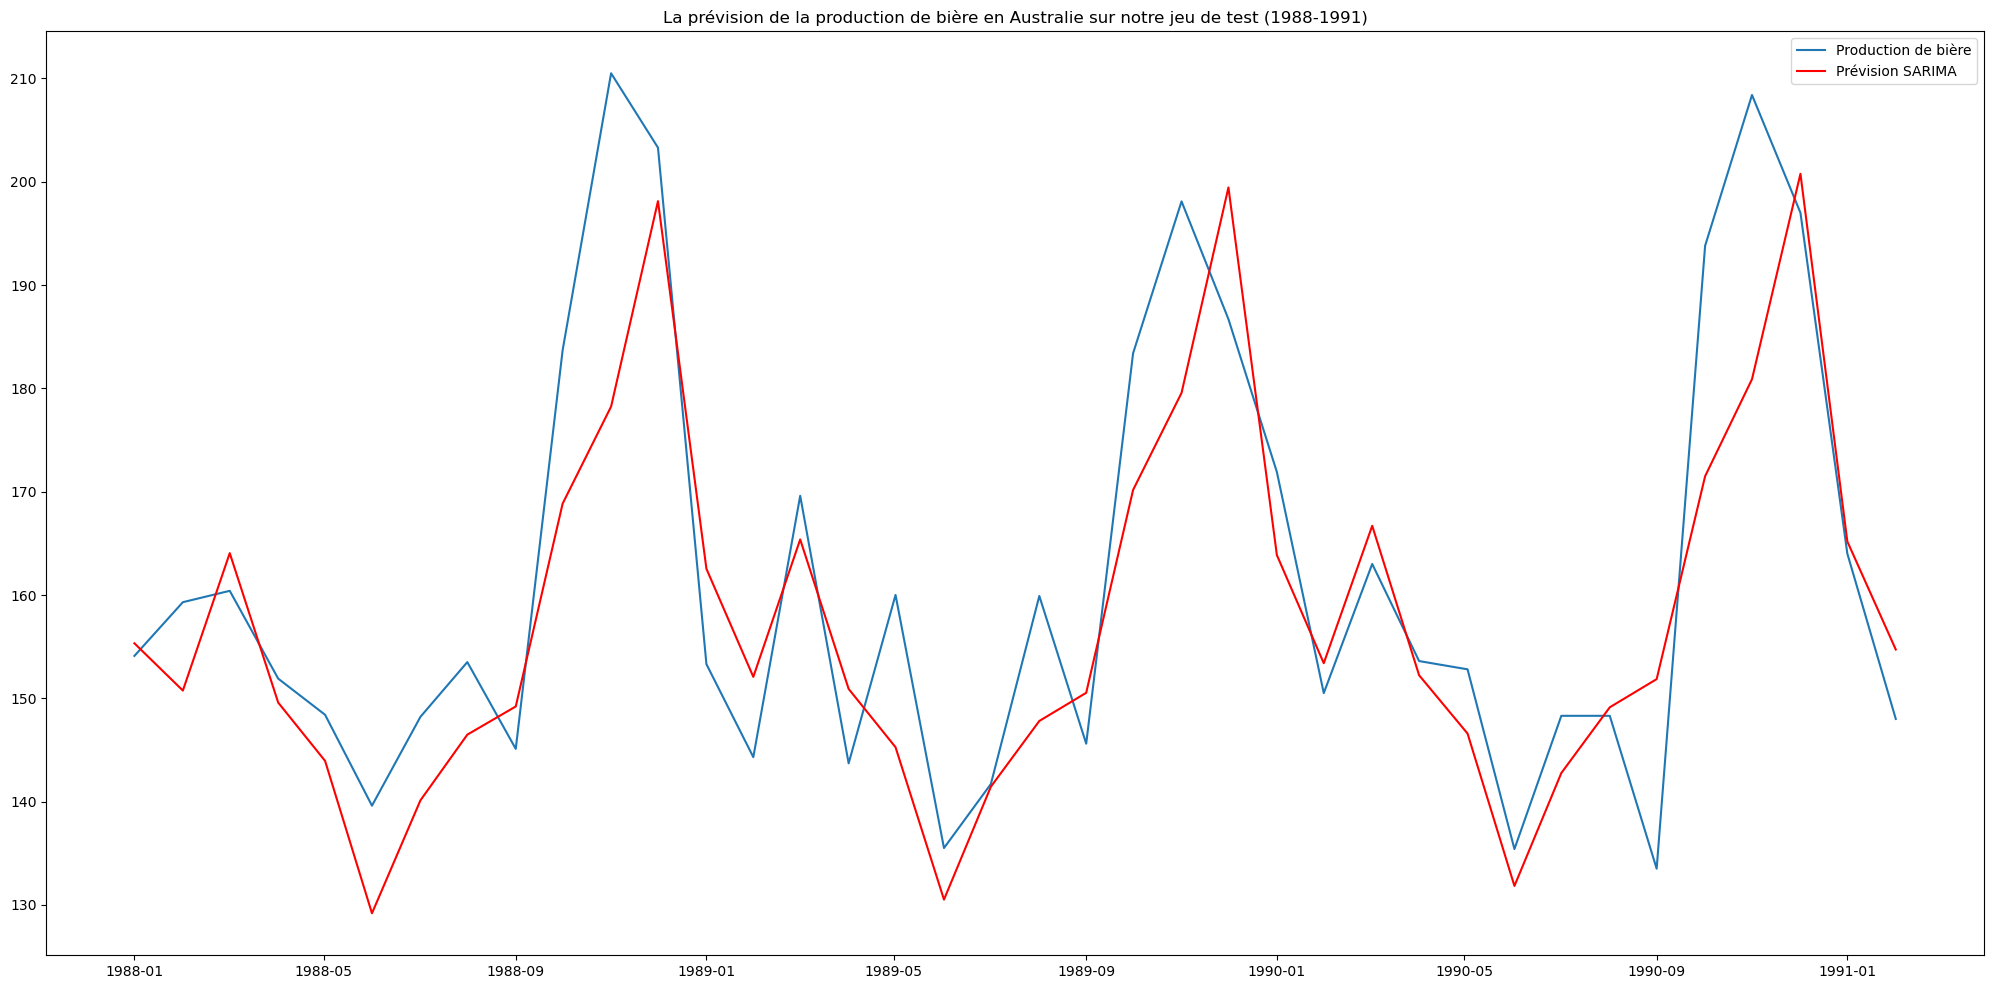

In [50]:
#Visualisation par restriction sur l'année 2018
pred_model_tronc = results_tronc.get_forecast(len(data_final_trucate2_test['beer']))
pred_tronc = pred_model_tronc.predicted_mean

plt.plot(data_final_trucate2_test['beer'], label='Production de bière')
plt.plot(data_final_trucate2_test.index, pred_tronc, color='r', label='Prévision SARIMA')


plt.title("La prévision de la production de bière en Australie sur notre jeu de test (1988-1991)")
        
plt.legend()
plt.savefig("C:/Users/dell/Desktop/Msc_ENSAI/Series_Temporelles/Evaluation-20230107/prevision_visu20182018_sarima_aposteriori.png")
plt.show()

In [51]:
mape = round((np.abs(1-pred_tronc/data_final_trucate2_test['beer'])).mean()*100, 2)
mape

5.05

In [52]:
from statsmodels.tools.eval_measures import rmse
start = len(data_final_trucate2_train)
end = len(data_final_trucate2_train) + len(data_final_trucate2_test) - 1
predictions = results_tronc.predict(start, end, typ = 'levels')
error = rmse(data_final_trucate2_test['beer'], predictions)
error

11.20958310597635

# Projet 2

In [53]:
data_ozone.head()

,maxO3,T6,T9,T12,T15,T18,Ne6,Ne9,Ne12,Ne15,...,Vdir9,Vvit9,Vdir12,Vvit12,Vdir15,Vvit15,Vdir18,Vvit18,Vx,maxO3v
19950401,47.6,10.1,11.6,13.3,13.6,12.2,8.0,8.0,8.0,8.0,...,290.0,4.0,300.0,4.0,340.0,4.0,20.0,4.0,-3.4641,62.2
19950402,56.2,9.5,9.4,13.8,17.4,16.3,8.0,8.0,7.0,0.0,...,160.0,2.0,180.0,3.0,110.0,1.0,350.0,2.0,0.0000,47.6
19950403,61.8,3.6,8.0,16.8,21.5,20.2,4.0,5.0,2.0,2.0,...,20.0,2.0,340.0,1.0,170.0,2.0,170.0,3.0,-0.3420,56.2
19950404,50.8,9.5,10.5,11.4,12.2,11.4,8.0,7.0,7.0,7.0,...,10.0,4.0,350.0,3.0,350.0,3.0,350.0,4.0,-0.5209,61.8
19950405,59.8,9.8,10.8,13.8,14.3,13.3,8.0,7.0,8.0,8.0,...,340.0,2.0,280.0,1.0,320.0,3.0,350.0,4.0,-0.9848,50.8


In [54]:
data_ozone.tail()

,maxO3,T6,T9,T12,T15,T18,Ne6,Ne9,Ne12,Ne15,...,Vdir9,Vvit9,Vdir12,Vvit12,Vdir15,Vvit15,Vdir18,Vvit18,Vx,maxO3v
20020926,76.0,7.0,13.7,17.0,17.9,15.3,4.0,7.0,8.0,7.0,...,290.0,4.0,330.0,5.0,330.0,6.0,330.0,3.0,-2.5000,79.0
20020927,79.0,10.2,11.5,18.3,20.0,17.1,9.0,9.0,2.0,6.0,...,70.0,2.0,120.0,1.0,90.0,3.0,100.0,2.0,0.8660,76.0
20020928,91.0,6.2,14.1,19.8,21.1,18.1,0.0,0.0,1.0,2.0,...,120.0,3.0,120.0,4.0,120.0,4.0,100.0,2.0,3.4641,79.0
20020929,89.0,8.1,14.8,20.4,22.0,18.4,4.0,5.0,5.0,4.0,...,120.0,4.0,130.0,5.0,130.0,4.0,140.0,1.0,3.8302,91.0
20020930,99.0,9.4,13.8,21.7,24.7,19.8,6.0,6.0,6.0,3.0,...,140.0,2.0,140.0,2.0,120.0,4.0,110.0,3.0,1.2856,89.0


In [55]:
data_ozone = data_ozone.dropna()

In [56]:
data_ozone = data_ozone.rename_axis('index').reset_index()

In [57]:
data_ozone

,index,maxO3,T6,T9,T12,T15,T18,Ne6,Ne9,Ne12,...,Vdir9,Vvit9,Vdir12,Vvit12,Vdir15,Vvit15,Vdir18,Vvit18,Vx,maxO3v
0,19950401,47.6,10.1,11.6,13.3,13.6,12.2,8.0,8.0,8.0,...,290.0,4.0,300.0,4.0,340.0,4.0,20.0,4.0,-3.4641,62.2
1,19950402,56.2,9.5,9.4,13.8,17.4,16.3,8.0,8.0,7.0,...,160.0,2.0,180.0,3.0,110.0,1.0,350.0,2.0,0.0000,47.6
2,19950403,61.8,3.6,8.0,16.8,21.5,20.2,4.0,5.0,2.0,...,20.0,2.0,340.0,1.0,170.0,2.0,170.0,3.0,-0.3420,56.2
3,19950404,50.8,9.5,10.5,11.4,12.2,11.4,8.0,7.0,7.0,...,10.0,4.0,350.0,3.0,350.0,3.0,350.0,4.0,-0.5209,61.8
4,19950405,59.8,9.8,10.8,13.8,14.3,13.3,8.0,7.0,8.0,...,340.0,2.0,280.0,1.0,320.0,3.0,350.0,4.0,-0.9848,50.8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1361,20020926,76.0,7.0,13.7,17.0,17.9,15.3,4.0,7.0,8.0,...,290.0,4.0,330.0,5.0,330.0,6.0,330.0,3.0,-2.5000,79.0
1362,20020927,79.0,10.2,11.5,18.3,20.0,17.1,9.0,9.0,2.0,...,70.0,2.0,120.0,1.0,90.0,3.0,100.0,2.0,0.8660,76.0
1363,20020928,91.0,6.2,14.1,19.8,21.1,18.1,0.0,0.0,1.0,...,120.0,3.0,120.0,4.0,120.0,4.0,100.0,2.0,3.4641,79.0
1364,20020929,89.0,8.1,14.8,20.4,22.0,18.4,4.0,5.0,5.0,...,120.0,4.0,130.0,5.0,130.0,4.0,140.0,1.0,3.8302,91.0


In [58]:
from datetime import datetime
data_ozone["index"] = data_ozone["index"].astype('str')
data_ozone["index"] = pd.to_datetime(data_ozone["index"])
data_ozone_train = data_ozone.loc[data_ozone["index"] < "2002-01-01"]
data_ozone_test = data_ozone.loc[data_ozone["index"]>="2002-01-01"]

In [59]:
data_ozone1 = data_ozone.set_index('index')
data_ozone1

,maxO3,T6,T9,T12,T15,T18,Ne6,Ne9,Ne12,Ne15,...,Vdir9,Vvit9,Vdir12,Vvit12,Vdir15,Vvit15,Vdir18,Vvit18,Vx,maxO3v
index,,,,,,,,,,,,,,,,,,,,,
1995-04-01,47.6,10.1,11.6,13.3,13.6,12.2,8.0,8.0,8.0,8.0,...,290.0,4.0,300.0,4.0,340.0,4.0,20.0,4.0,-3.4641,62.2
1995-04-02,56.2,9.5,9.4,13.8,17.4,16.3,8.0,8.0,7.0,0.0,...,160.0,2.0,180.0,3.0,110.0,1.0,350.0,2.0,0.0000,47.6
1995-04-03,61.8,3.6,8.0,16.8,21.5,20.2,4.0,5.0,2.0,2.0,...,20.0,2.0,340.0,1.0,170.0,2.0,170.0,3.0,-0.3420,56.2
1995-04-04,50.8,9.5,10.5,11.4,12.2,11.4,8.0,7.0,7.0,7.0,...,10.0,4.0,350.0,3.0,350.0,3.0,350.0,4.0,-0.5209,61.8
1995-04-05,59.8,9.8,10.8,13.8,14.3,13.3,8.0,7.0,8.0,8.0,...,340.0,2.0,280.0,1.0,320.0,3.0,350.0,4.0,-0.9848,50.8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2002-09-26,76.0,7.0,13.7,17.0,17.9,15.3,4.0,7.0,8.0,7.0,...,290.0,4.0,330.0,5.0,330.0,6.0,330.0,3.0,-2.5000,79.0
2002-09-27,79.0,10.2,11.5,18.3,20.0,17.1,9.0,9.0,2.0,6.0,...,70.0,2.0,120.0,1.0,90.0,3.0,100.0,2.0,0.8660,76.0
2002-09-28,91.0,6.2,14.1,19.8,21.1,18.1,0.0,0.0,1.0,2.0,...,120.0,3.0,120.0,4.0,120.0,4.0,100.0,2.0,3.4641,79.0


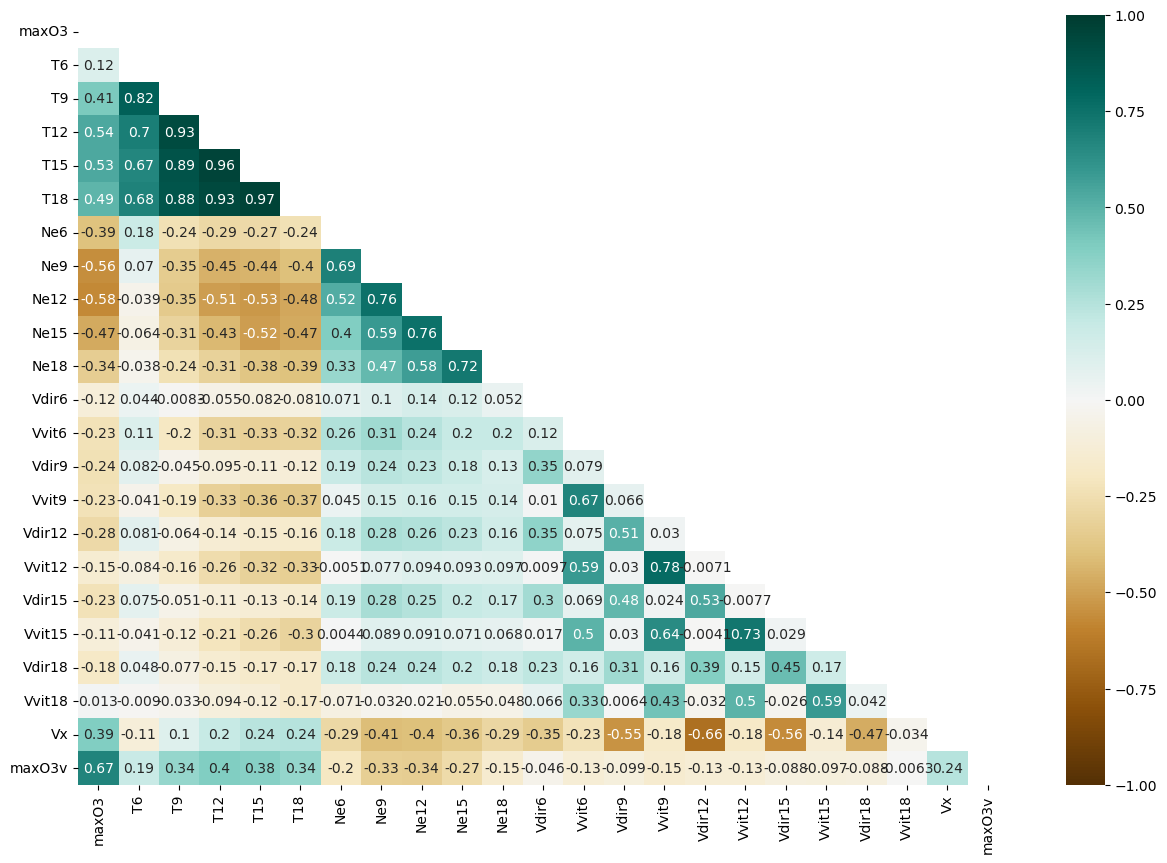

In [60]:
plt.rcParams["figure.figsize"] = [15,10]
mask = np.triu(np.ones_like(data_ozone1.corr(), dtype=np.bool))
corr = data_ozone1.corr()
heatmap = sns.heatmap(corr, annot=True, mask = mask, vmin=-1, vmax=1, cmap='BrBG')
plt.show()

In [61]:
data_ozone_train = data_ozone_train.set_index("index")

In [62]:
data_ozone_train.head()

,maxO3,T6,T9,T12,T15,T18,Ne6,Ne9,Ne12,Ne15,...,Vdir9,Vvit9,Vdir12,Vvit12,Vdir15,Vvit15,Vdir18,Vvit18,Vx,maxO3v
index,,,,,,,,,,,,,,,,,,,,,
1995-04-01,47.6,10.1,11.6,13.3,13.6,12.2,8.0,8.0,8.0,8.0,...,290.0,4.0,300.0,4.0,340.0,4.0,20.0,4.0,-3.4641,62.2
1995-04-02,56.2,9.5,9.4,13.8,17.4,16.3,8.0,8.0,7.0,0.0,...,160.0,2.0,180.0,3.0,110.0,1.0,350.0,2.0,0.0000,47.6
1995-04-03,61.8,3.6,8.0,16.8,21.5,20.2,4.0,5.0,2.0,2.0,...,20.0,2.0,340.0,1.0,170.0,2.0,170.0,3.0,-0.3420,56.2
1995-04-04,50.8,9.5,10.5,11.4,12.2,11.4,8.0,7.0,7.0,7.0,...,10.0,4.0,350.0,3.0,350.0,3.0,350.0,4.0,-0.5209,61.8
1995-04-05,59.8,9.8,10.8,13.8,14.3,13.3,8.0,7.0,8.0,8.0,...,340.0,2.0,280.0,1.0,320.0,3.0,350.0,4.0,-0.9848,50.8


In [63]:
data_ozone_test = data_ozone_test.set_index("index")

In [64]:
data_ozone_test.tail()

,maxO3,T6,T9,T12,T15,T18,Ne6,Ne9,Ne12,Ne15,...,Vdir9,Vvit9,Vdir12,Vvit12,Vdir15,Vvit15,Vdir18,Vvit18,Vx,maxO3v
index,,,,,,,,,,,,,,,,,,,,,
2002-09-26,76.0,7.0,13.7,17.0,17.9,15.3,4.0,7.0,8.0,7.0,...,290.0,4.0,330.0,5.0,330.0,6.0,330.0,3.0,-2.5000,79.0
2002-09-27,79.0,10.2,11.5,18.3,20.0,17.1,9.0,9.0,2.0,6.0,...,70.0,2.0,120.0,1.0,90.0,3.0,100.0,2.0,0.8660,76.0
2002-09-28,91.0,6.2,14.1,19.8,21.1,18.1,0.0,0.0,1.0,2.0,...,120.0,3.0,120.0,4.0,120.0,4.0,100.0,2.0,3.4641,79.0
2002-09-29,89.0,8.1,14.8,20.4,22.0,18.4,4.0,5.0,5.0,4.0,...,120.0,4.0,130.0,5.0,130.0,4.0,140.0,1.0,3.8302,91.0
2002-09-30,99.0,9.4,13.8,21.7,24.7,19.8,6.0,6.0,6.0,3.0,...,140.0,2.0,140.0,2.0,120.0,4.0,110.0,3.0,1.2856,89.0


In [65]:
data_ozone_test.columns

Index(['maxO3', 'T6', 'T9', 'T12', 'T15', 'T18', 'Ne6', 'Ne9', 'Ne12', 'Ne15',
       'Ne18', 'Vdir6', 'Vvit6', 'Vdir9', 'Vvit9', 'Vdir12', 'Vvit12',
       'Vdir15', 'Vvit15', 'Vdir18', 'Vvit18', 'Vx', 'maxO3v'],
      dtype='object')

In [66]:
data_ozone_test.shape

(180, 23)

### Step 0: La statistique descriptive et la selection de variables.

In [67]:
data_ozone_T = data_ozone.iloc[:,[23,1]]
#range(8,

In [68]:
data_ozone_T

,maxO3v,maxO3
0,62.2,47.6
1,47.6,56.2
2,56.2,61.8
3,61.8,50.8
4,50.8,59.8
...,...,...
1361,79.0,76.0
1362,76.0,79.0
1363,79.0,91.0
1364,91.0,89.0


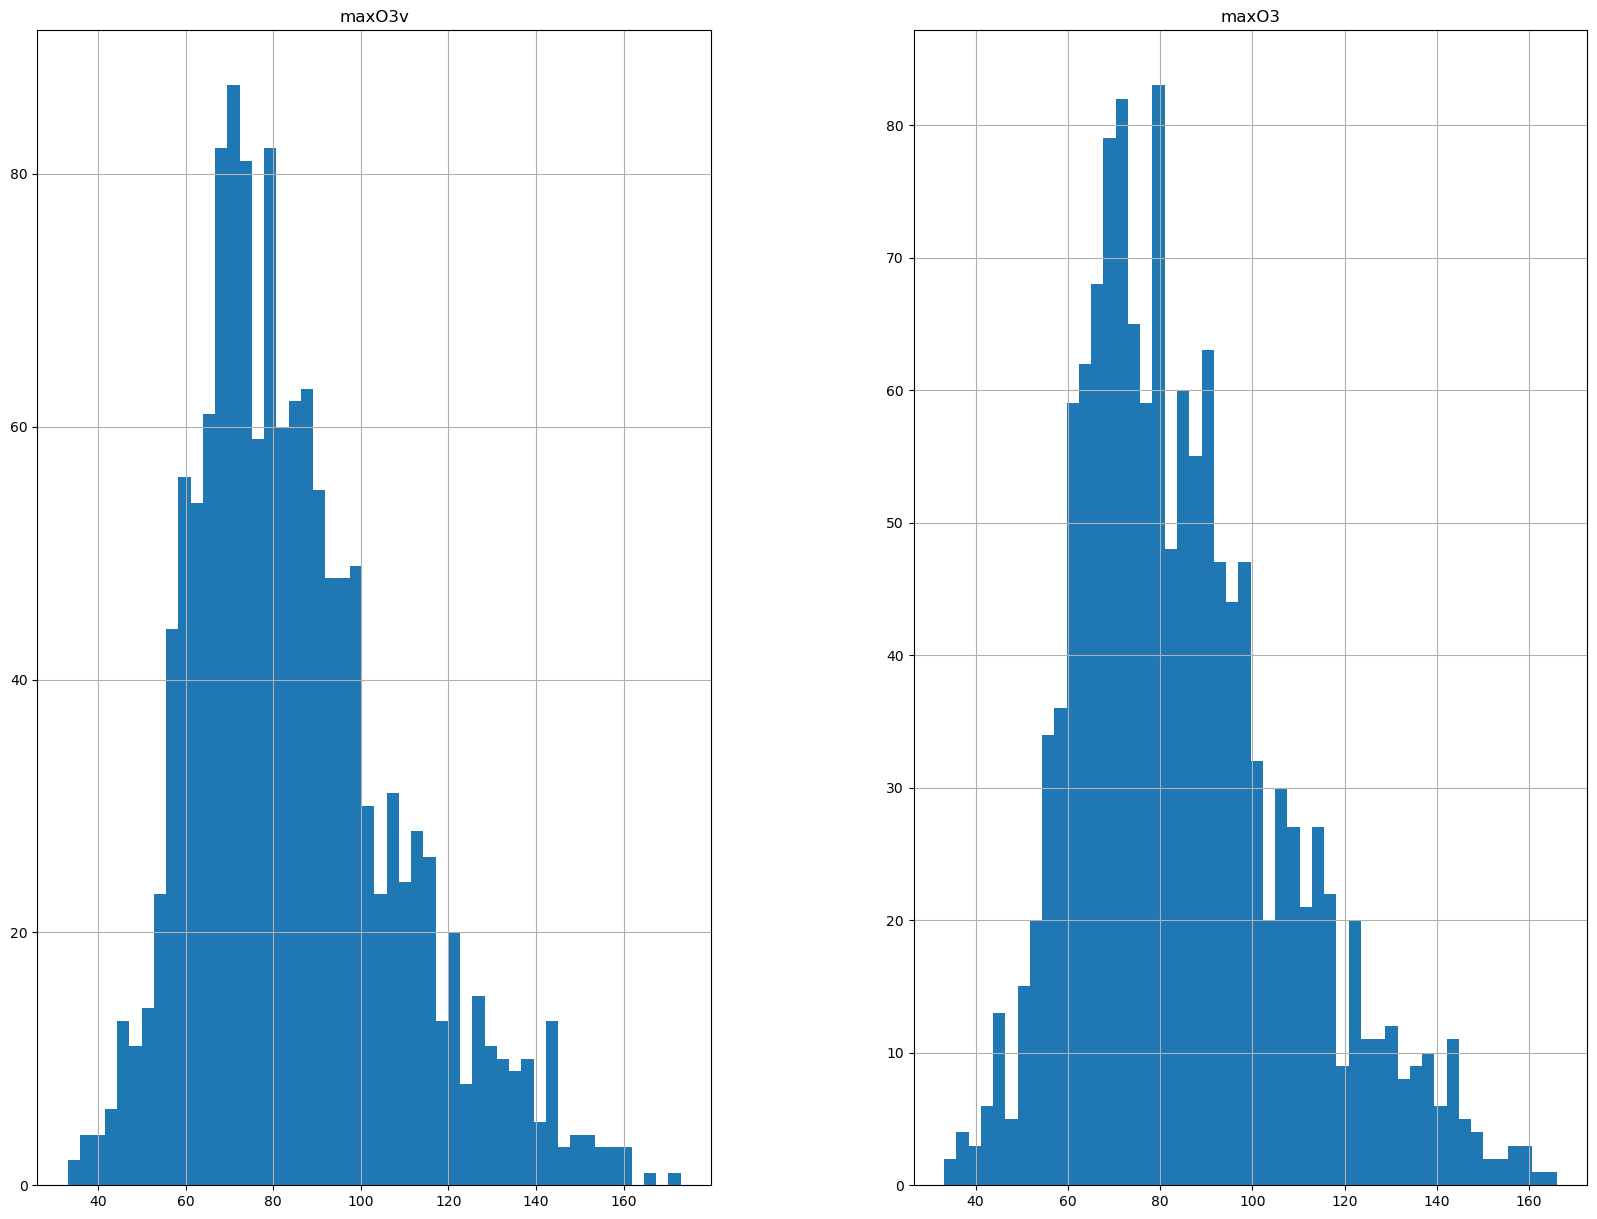

In [69]:
numerical_variables = data_ozone_T.select_dtypes(['int64', 'float64']).columns
train_data_numerical_variables = data_ozone_T[numerical_variables]
train_data_numerical_variables.hist(bins = 50, figsize=(20,15))
plt.show()

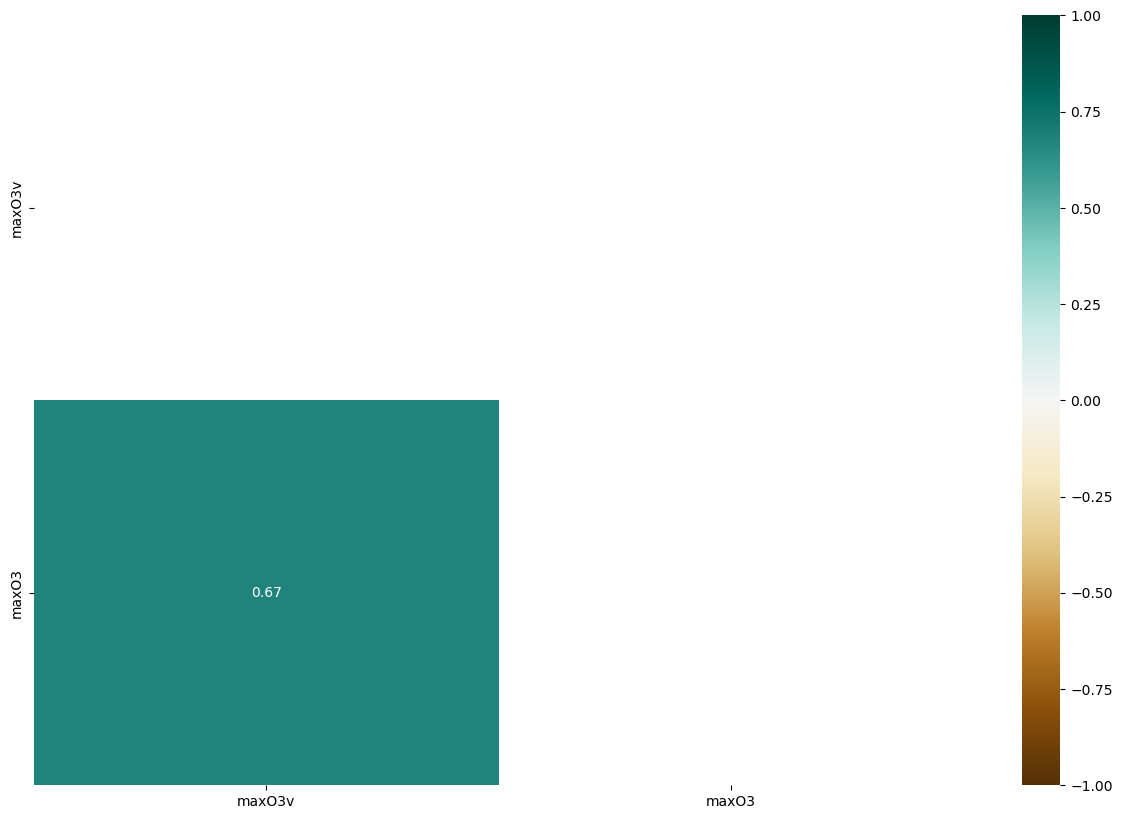

In [70]:
plt.rcParams["figure.figsize"] = [15,10]
mask = np.triu(np.ones_like(train_data_numerical_variables.corr(), dtype=np.bool))
corr = train_data_numerical_variables.corr()
heatmap = sns.heatmap(corr, annot=True, mask = mask, vmin=-1, vmax=1, cmap='BrBG')
plt.show()

In [72]:
corr

,maxO3v,maxO3
maxO3v,1.0000,0.6745
maxO3,0.6745,1.0000


In [73]:
#corr.iloc[:,5].sort_values()

In [76]:
numerical_variables = ["T12","Ne9"]
#numerical_variables = ["T6","T12", "T15","T18","Ne9","Ne12","Vvit6","Vdir9","Vvit9","Vdir18","Vvit18","Vx"]
data_ozone_train1 = data_ozone_train.loc[:,numerical_variables]
data_ozone_test1 = data_ozone_test.loc[:,numerical_variables]

In [77]:
data_ozone_train

,maxO3,T6,T9,T12,T15,T18,Ne6,Ne9,Ne12,Ne15,...,Vdir9,Vvit9,Vdir12,Vvit12,Vdir15,Vvit15,Vdir18,Vvit18,Vx,maxO3v
index,,,,,,,,,,,,,,,,,,,,,
1995-04-01,47.6,10.1,11.6,13.3,13.6,12.2,8.0,8.0,8.0,8.0,...,290.0,4.0,300.0,4.0,340.0,4.0,20.0,4.0,-3.4641,62.2
1995-04-02,56.2,9.5,9.4,13.8,17.4,16.3,8.0,8.0,7.0,0.0,...,160.0,2.0,180.0,3.0,110.0,1.0,350.0,2.0,0.0000,47.6
1995-04-03,61.8,3.6,8.0,16.8,21.5,20.2,4.0,5.0,2.0,2.0,...,20.0,2.0,340.0,1.0,170.0,2.0,170.0,3.0,-0.3420,56.2
1995-04-04,50.8,9.5,10.5,11.4,12.2,11.4,8.0,7.0,7.0,7.0,...,10.0,4.0,350.0,3.0,350.0,3.0,350.0,4.0,-0.5209,61.8
1995-04-05,59.8,9.8,10.8,13.8,14.3,13.3,8.0,7.0,8.0,8.0,...,340.0,2.0,280.0,1.0,320.0,3.0,350.0,4.0,-0.9848,50.8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2001-09-25,84.0,10.6,13.3,17.7,17.8,16.5,7.0,3.0,5.0,6.0,...,0.0,0.0,210.0,2.0,320.0,2.0,230.0,3.0,-1.0000,76.0
2001-09-27,77.0,13.5,16.2,20.8,22.1,20.0,8.0,6.0,5.0,5.0,...,190.0,4.0,210.0,4.0,200.0,4.0,170.0,1.0,-2.0000,71.0
2001-09-28,99.0,11.7,16.9,23.0,22.6,18.9,6.0,6.0,4.0,7.0,...,150.0,3.0,170.0,5.0,170.0,5.0,160.0,2.0,0.8682,77.0


In [78]:
data_ozone_test

,maxO3,T6,T9,T12,T15,T18,Ne6,Ne9,Ne12,Ne15,...,Vdir9,Vvit9,Vdir12,Vvit12,Vdir15,Vvit15,Vdir18,Vvit18,Vx,maxO3v
index,,,,,,,,,,,,,,,,,,,,,
2002-04-01,109.0,7.8,10.4,14.7,15.3,14.3,8.0,6.0,6.0,5.0,...,160.0,2.0,230.0,4.0,270.0,2.0,220.0,1.0,-3.0642,111.0
2002-04-02,96.0,7.7,11.0,18.3,19.7,18.1,7.0,5.0,7.0,2.0,...,120.0,3.0,140.0,4.0,160.0,7.0,200.0,5.0,2.5712,109.0
2002-04-03,73.0,11.0,11.9,13.8,11.7,11.4,8.0,8.0,8.0,8.0,...,140.0,2.0,80.0,1.0,100.0,3.0,30.0,2.0,0.9848,96.0
2002-04-04,84.0,9.9,10.6,14.6,15.5,13.0,7.0,7.0,5.0,3.0,...,300.0,2.0,300.0,5.0,320.0,5.0,320.0,4.0,-4.3301,73.0
2002-04-05,78.0,6.8,8.6,12.9,13.9,12.5,8.0,8.0,7.0,6.0,...,110.0,3.0,160.0,3.0,210.0,3.0,160.0,1.0,1.0261,84.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2002-09-26,76.0,7.0,13.7,17.0,17.9,15.3,4.0,7.0,8.0,7.0,...,290.0,4.0,330.0,5.0,330.0,6.0,330.0,3.0,-2.5000,79.0
2002-09-27,79.0,10.2,11.5,18.3,20.0,17.1,9.0,9.0,2.0,6.0,...,70.0,2.0,120.0,1.0,90.0,3.0,100.0,2.0,0.8660,76.0
2002-09-28,91.0,6.2,14.1,19.8,21.1,18.1,0.0,0.0,1.0,2.0,...,120.0,3.0,120.0,4.0,120.0,4.0,100.0,2.0,3.4641,79.0


## Step 1: Pre-Processing

In [79]:
#numerical_variables = data_ozone_train.select_dtypes(['int64', 'float64']).columns
# Entrainement d'un modèle d'standarScaler avec les donnée d'entrainement 
standardScaler= StandardScaler().fit(data_ozone_train1[numerical_variables])
#application sur les variables d'entrainement 
data_ozone_train1.loc[:,numerical_variables]=standardScaler.transform(data_ozone_train1[numerical_variables])
#application sur les variables de test 
data_ozone_test1.loc[:,numerical_variables]=standardScaler.transform(data_ozone_test1[numerical_variables])

In [80]:
data_ozone_train1

,T12,Ne9
index,,
1995-04-01,-1.235758,1.111567
1995-04-02,-1.136019,1.111567
1995-04-03,-0.537583,-0.063056
1995-04-04,-1.614768,0.720026
1995-04-05,-1.136019,0.720026
...,...,...
2001-09-25,-0.358052,-0.846138
2001-09-27,0.260331,0.328485
2001-09-28,0.699184,0.328485


In [81]:
y_train = data_ozone_train["maxO3"]
y_test = data_ozone_test["maxO3"]

In [82]:
from sklearn.metrics import mean_absolute_error

In [83]:
#RFR_model = RandomForestRegressor(n_estimators=50, max_depth=10, min_samples_leaf=7, random_state=0,verbose=1)
RFR_model = RandomForestRegressor(n_estimators=50, max_depth=10, random_state=0)

In [84]:
# avec variable encoded 
# Entraînement :
#scores = cross_validate(clf, X, y, scoring=scoring)
%time RFR_model.fit(data_ozone_train1, y_train)
# %time MLPR_model.fit(x_train_ohe, y_train)

# Prédiction sur le jeu de test :
y_test_rfrt1 = RFR_model.predict(data_ozone_train1)
y_test_rfr = RFR_model.predict(data_ozone_test1)
# y_test_mlpr = MLPR_model.predict(x_test_ohe)

Wall time: 266 ms


In [85]:
from sklearn.metrics import mean_squared_error
import math

MSE = mean_squared_error(y_test, y_test_rfr)
MAE = mean_absolute_error(y_test, y_test_rfr)
RMSE = math.sqrt(MSE)

MSET = mean_squared_error(y_train, y_test_rfrt1)
RMSET = math.sqrt(MSET)

In [86]:
print(RMSET)
print(RMSE)

11.724842869857422
17.793480305184588


In [87]:
#data_ozone_test["maxO3"].plot(label = "La teneur en Ozone")
data_ozone_test["maxO3Predic"]=y_test_rfr
#data_ozone_test["maxO3Predic"].plot(label="Prévision de la teneur en Ozone")
#plt.draw()

In [88]:
results.test_normality("jarquebera")[0][1]

0.020291560664603928

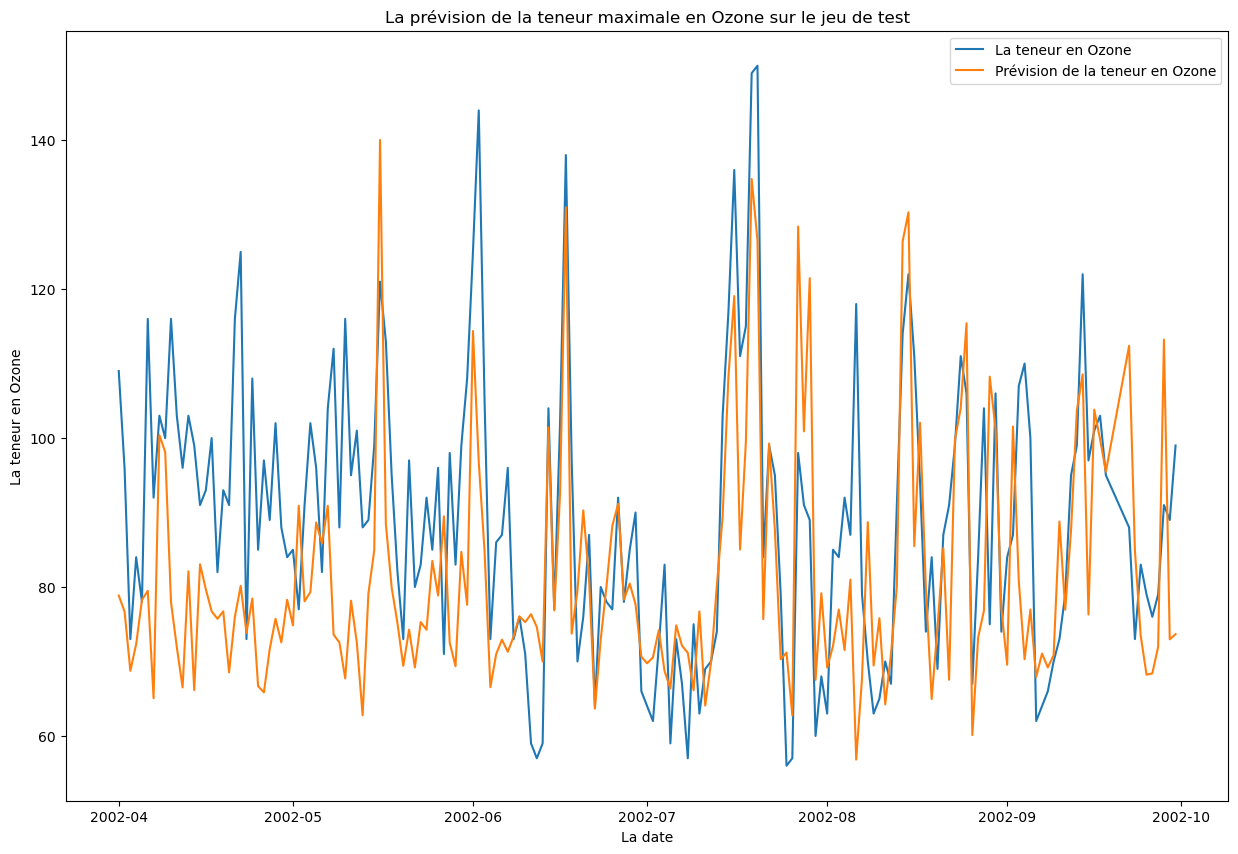

In [89]:
plt.plot(data_ozone_test["maxO3"], label = "La teneur en Ozone")
plt.plot(data_ozone_test["maxO3Predic"], label="Prévision de la teneur en Ozone")
plt.title("La prévision de la teneur maximale en Ozone sur le jeu de test")

plt.ylabel('La teneur en Ozone')
plt.xlabel('La date')

plt.legend()
plt.draw()

In [90]:
def rmse(predictions, targets):
    return np.sqrt(((predictions - targets) ** 2).mean())

In [91]:
rmse(y_test_rfr, y_test)

17.793480305184588

## -- Exercice 2:

In [92]:
numerical_variables = ["T12","Ne9","maxO3v"]
#numerical_variables = ["T6","T12", "T15","T18","Ne9","Ne12","Vvit6","Vdir9","Vvit9","Vdir18","Vvit18","Vx"]
data_ozone_train1 = data_ozone_train.loc[:,numerical_variables]
data_ozone_test1 = data_ozone_test.loc[:,numerical_variables]

In [93]:
#numerical_variables = data_ozone_train.select_dtypes(['int64', 'float64']).columns
# Entrainement d'un modèle d'standarScaler avec les donnée d'entrainement 
standardScaler= StandardScaler().fit(data_ozone_train1[numerical_variables])
#application sur les variables d'entrainement 
data_ozone_train1.loc[:,numerical_variables]=standardScaler.transform(data_ozone_train1[numerical_variables])
#application sur les variables de test 
data_ozone_test1.loc[:,numerical_variables]=standardScaler.transform(data_ozone_test1[numerical_variables])

In [94]:
y_train = data_ozone_train["maxO3"]
y_test = data_ozone_test["maxO3"]

In [95]:
from sklearn.metrics import mean_absolute_error

In [96]:
#RFR_model = RandomForestRegressor(n_estimators=50, max_depth=10, min_samples_leaf=7, random_state=0,verbose=1)
RFR_model = RandomForestRegressor(n_estimators=50, max_depth=10, random_state=0)

In [97]:
# avec variable encoded 
# Entraînement :
#scores = cross_validate(clf, X, y, scoring=scoring)
%time RFR_model.fit(data_ozone_train1, y_train)
# %time MLPR_model.fit(x_train_ohe, y_train)

# Prédiction sur le jeu de test :
y_test_rfr1 = RFR_model.predict(data_ozone_train1)
y_test_rfr = RFR_model.predict(data_ozone_test1)
# y_test_mlpr = MLPR_model.predict(x_test_ohe)

Wall time: 234 ms


In [98]:
from sklearn.metrics import mean_squared_error
import math

MSE = mean_squared_error(y_test, y_test_rfr)
MAE = mean_absolute_error(y_test, y_test_rfr)
RMSE = math.sqrt(MSE)
MSE1 = mean_squared_error(y_train, y_test_rfr1)
RMSE1 = math.sqrt(MSE1)

In [99]:
print(RMSE1)
print(RMSE)

7.815409121411083
14.38494799990698


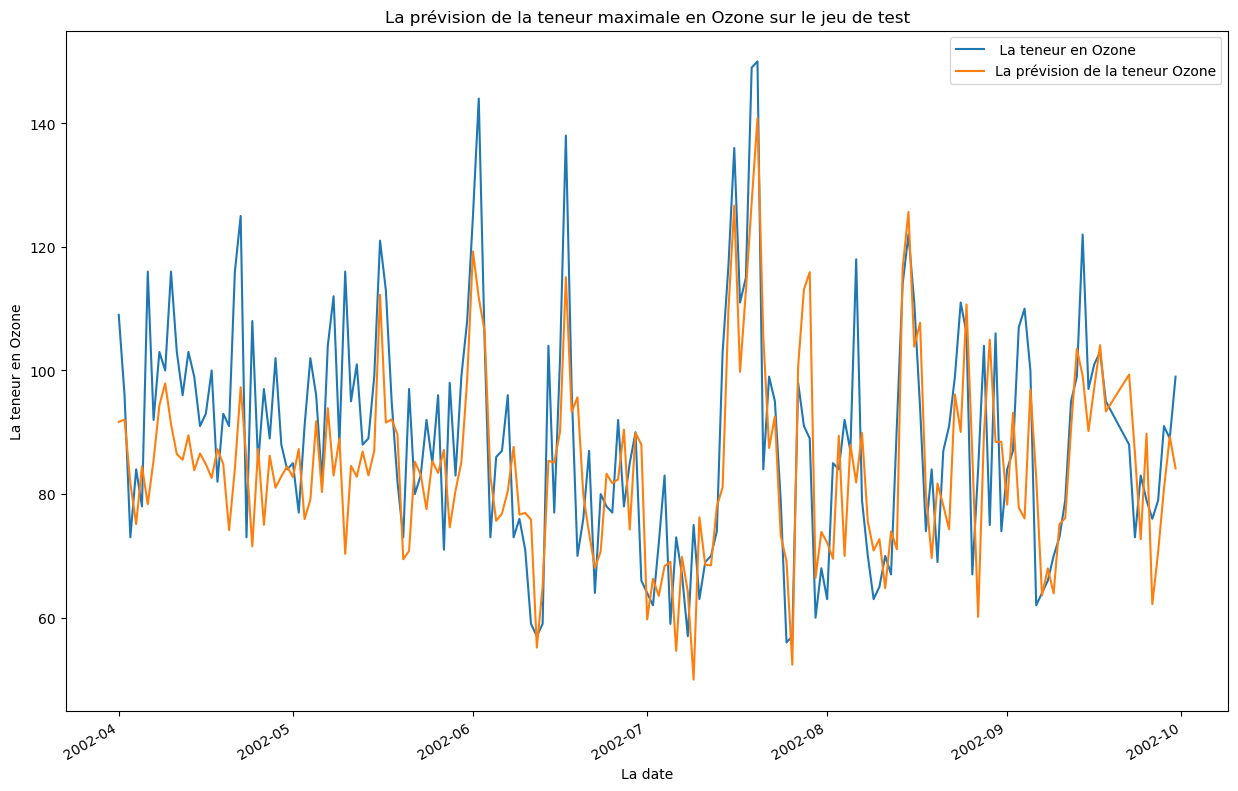

In [100]:
data_ozone_test["maxO3"].plot(label = " La teneur en Ozone")
data_ozone_test["maxO3Predic"]=y_test_rfr
data_ozone_test["maxO3Predic"].plot(label = "La prévision de la teneur Ozone")

plt.title("La prévision de la teneur maximale en Ozone sur le jeu de test")

plt.ylabel('La teneur en Ozone')
plt.xlabel('La date')

plt.legend()
plt.draw()

In [101]:
rmse(y_test_rfr, y_test)

14.384947999906982